In [343]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [344]:
# Utils
import os
import json
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import norm, lognorm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn import metrics
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from joblib import Parallel, delayed
import random
from scipy import interpolate

# Models
from sklearn.neural_network import MLPClassifier
from torch.optim import Adam, RMSprop, SGD
from tqdm import tqdm
from scipy import interpolate
# from opacus import PrivacyEngine

# Data
from torch.utils.data import DataLoader
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_classification

# Seeds
import random
torch.manual_seed(12345678910)
random.seed(12345678910)

In [345]:
## for Palatino and other serif fonts use:
# Seaborn style
sns.set_theme(style="whitegrid", font_scale=1.25)
from matplotlib import rc
font = {'family': 'serif',
        'weight': 'bold',
        'serif': ['Palatino'],
        'size': 20}
rc('font', **font)
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams['axes.autolimit_mode']

'data'

In [346]:
class Loader(data.Dataset):
    def __init__(self, X: np.array, y: np.array):
        
        """
        Load training dataset
        :param path: string with path to training set
        :param label: string, column name for label
        :param scale: string; either 'minmax' or 'standard'
        :return: tensor with training data
        """
        
        # Load dataset
        self.y= y

        # Save target and predictors
        self.X = X
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # select correct row with idx
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()
        return self.X[idx], self.y[idx], idx

    def get_number_of_features(self):
        return self.X.shape[1]
    
    def get_number_of_instances(self):
        return self.y.shape[0]


In [347]:
class ann(nn.Module):
    def __init__(self, input_dim: int, 
                 hidden_layers: list,
                 train_loader,
                 num_of_classes: int = 1, 
                 fit_sklearn=False, 
                 epochs=750,
                 multiplier=None):
        
        super().__init__()
        self.hidden_layers = hidden_layers
        self.input_dim = input_dim
        self.fit_sklearn = fit_sklearn
        self.optim = "sgd"
        self.n_epochs = epochs
        self.multiplier = multiplier
        self.train_loader = train_loader
        self.delta = parameters_MODEL['delta']
        
        
        # input layer
        self.input1 = nn.Linear(input_dim, self.hidden_layers[0])
        
        # second layer if necessary
        if len(hidden_layers) == 2:
            self.input2 = nn.Linear(self.hidden_layers[1], self.hidden_layers[1])
            self.input3 = nn.Linear(hidden_layers[1], num_of_classes)
        else:
            # output layer
            self.input3 = nn.Linear(hidden_layers[0], num_of_classes)

        # Activation
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def fit(self, model, X: np.array, y: np.array):

        if self.fit_sklearn:
            self._fit_sklearn(X, y)
        else:
            self._fit_sgd(model, torch.tensor(X).float(), torch.tensor(y).float())
    
    def _fit_sklearn(self, 
                     X: np.array, 
                     y: np.array):
        
        num_inputs = len(X)
        sklearn_ann = MLPClassifier(hidden_layer_sizes=self.hidden_layers, 
                                    solver='lbfgs',
                                    activation='relu', 
                                    alpha=0.0, 
                                    max_iter=750, 
                                    tol=1e-4)
        sklearn_ann.fit(X, y)
        self.input1.weight.data = torch.tensor(sklearn_ann.coefs_[0], dtype=torch.float32).t()
        self.input1.bias.data = torch.tensor(sklearn_ann.intercepts_[0], dtype=torch.float32).flatten()
        
        if len(self.hidden_layers) == 2:
            self.input2.weight.data = torch.tensor(sklearn_ann.coefs_[1], dtype=torch.float32).t()
            self.input2.bias.data = torch.tensor(sklearn_ann.intercepts_[1], dtype=torch.float32).flatten()
            
            self.input3.weight.data = torch.tensor(sklearn_ann.coefs_[2], dtype=torch.float32).t()
            self.input3.bias.data = torch.tensor(sklearn_ann.intercepts_[2], dtype=torch.float32).flatten()
        else:
            self.input3.weight.data = torch.tensor(sklearn_ann.coefs_[1], dtype=torch.float32).t()
            self.input3.bias.data = torch.tensor(sklearn_ann.intercepts_[1], dtype=torch.float32).flatten()
        print("Sklearn loss:", sklearn_ann.loss_)
        
    
    def _fit_sgd(self, 
                 model, 
                 X: torch.tensor,
                 y: torch.tensor):
        """ Fit with stochastic Gradiend Descent. """
    
        criterion = nn.BCELoss(reduction='none')
        
        current_lr = 0.001
        if self.optim == "adam":
            optim = Adam(model.parameters(), lr=current_lr)
        elif self.optim == "sgd":
            optim = SGD(model.parameters(), lr=current_lr)
        else:
            raise ValueError("Currently adam and sgd are supported.")
        
        if self.multiplier is not None:
            privacy_engine = PrivacyEngine(model,
                                   batch_size=X.shape[0],
                                   sample_size=X.shape[0],
                                   alphas=range(0, 30000),
                                   max_grad_norm=1.0,
                                   epochs=self.n_epochs,
                                   target_epsilon=parameters_MODEL['epsilon'],
                                   target_delta=parameters_MODEL['delta'],
                                   )
            privacy_engine.attach(optim)
        

        for e in range(self.n_epochs):
            if e % 5 == 0:
                print('Epoch {}/{}'.format(e, self.n_epochs - 1))
                print('-' * 10)

            running_loss = 0.0
            running_acc = 0.0
            running_f1 = 0.0

            for i, (inputs, labels, indeces) in enumerate(self.train_loader):

                labels = labels.type(torch.long)

                torch.set_grad_enabled(True)
                y_pred = model(inputs.float()).reshape(-1)
                loss = torch.mean(criterion(y_pred.float(), labels.float()))

                # backward + optimize only if in training phase
                loss.backward()
                optim.step()

                # statistics
                preds = y_pred.data >= 0.5
                running_acc += accuracy_score(labels.numpy(), preds.view(-1).long().numpy())
                running_loss += loss.item()  # * inputs.size(0)
                running_f1 += f1_score(labels.numpy(), preds.view(-1).long().numpy())

                epoch_loss = running_loss / (i + 1)
                epoch_acc = running_acc / (i + 1)
                epoch_f1 = running_f1 / (i + 1)
                
                if self.multiplier is not None:
                    epsilon, best_alpha = optim.privacy_engine.get_privacy_spent(self.delta)

                    print(
                        f"Train Epoch: {e} \t"
                        f"(ε = {epsilon:.2f}, delta = {self.delta}) for alpha = {best_alpha}")
                
                optim.zero_grad()


    def forward(self, x):
        """
        Forward pass through the network
        Parameters
        ----------
        x: tabular data input
        Returns
        -------
        prediction
        """
        
        output = self.input1(x)
        output = self.relu(output)
        
        if len(self.hidden_layers) == 2:
            output = self.input2(output)
            output = self.relu(output)
        
        output = self.input3(output)
        output = self.sigmoid(output)
        return output.reshape(-1)

In [348]:
class VAE_model(nn.Module):
    
    def __init__(self, 
                 D: int, 
                 activFun=nn.Softplus(), 
                 d: int = 6,
                 H1: int = 25, 
                 H2: int = 25):
        super(VAE_model, self).__init__()

        # The VAE components
        self.enc = nn.Sequential(
            nn.Linear(D, H1),
            activFun,
            nn.Linear(H1, H2),
            activFun
        )

        self.mu_enc = nn.Sequential(
            self.enc,
            nn.Linear(H2, d)
        )

        self.log_var_enc = nn.Sequential(
            self.enc,
            nn.Linear(H2, d)
        )

        self.dec = nn.Sequential(
            nn.Linear(d, H2),
            activFun,
            nn.Linear(H2, H1),
            activFun
        )

        self.mu_dec = nn.Sequential(
            self.dec,
            nn.Linear(H1, D)
        )

        self.log_var_dec = nn.Sequential(
            self.dec,
            nn.Linear(H1, D)
        )

    def encode(self, x):
        return self.mu_enc(x), self.log_var_enc(x)
    
    def encode_csearch(self, x):
        return self.mu_enc(x)

    def decode(self, z):
        return self.mu_dec(z), self.log_var_dec(z)
    
    def decode_csearch(self, z):
        return self.mu_dec(z)

    @staticmethod
    def reparametrization_trick(mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)  # the Gaussian random noise
        return mu + std * epsilon

    def forward(self, x):
        mu_z, log_var_z = self.encode(x)
        z_rep = self.reparametrization_trick(mu_z, log_var_z)
        mu_x, log_var_x = self.decode(z_rep)

        return mu_x, log_var_x, z_rep, mu_z, log_var_z

    def predict(self, data):
            return self.forward(data)
    
    def regenerate(self, z, grad=False):
        mu_x, log_var_x = self.decode(z)
        return mu_x

    # Computes the objective function of the VAE
    def VAE_loss(self, x, mu_x, log_var_x, mu_z, log_var_z, r=0.25):
        D = mu_x.shape[1]
        d = mu_z.shape[1]

        if log_var_x.shape[1] == 1:
            P_X_Z = + 0.5 * (D * log_var_x + (((x - mu_x) ** 2) / log_var_x.exp()).sum(dim=1, keepdim=True)).mean()
        else:
            P_X_Z = + 0.5 * (log_var_x.sum(dim=1, keepdim=True)
                            + (((x - mu_x) ** 2) / log_var_x.exp()).sum(dim=1, keepdim=True)).mean()

        if log_var_z.shape[1] == 1:
            Q_Z_X = - 0.5 * (d * log_var_z).mean()
        else:
            Q_Z_X = - 0.5 * log_var_z.sum(dim=1, keepdim=True).mean()

        if log_var_z.shape[1] == 1:
            P_Z = + 0.5 * ((mu_z ** 2).sum(dim=1, keepdim=True) + d * log_var_z.exp()).mean()
        else:
            P_Z = + 0.5 * ((mu_z ** 2).sum(dim=1, keepdim=True) + log_var_z.exp().sum(dim=1, keepdim=True)).mean()

        return P_X_Z + r * Q_Z_X + r * P_Z
    
    
    def fit(self, 
            model, 
            train_loader, 
            test_loader, 
            learning_rate=0.002, 
            epochs=50, 
            batch_size=32, 
            lambda_reg=1e-6):
    
        loaders = {'train': train_loader,
                   'test': test_loader}

        optimizer_model = torch.optim.Adam(model.parameters(),
                                           lr=learning_rate,
                                           weight_decay=lambda_reg)

        # Use GPU if available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        # Train the VAE with the new prior
        ELBO_train = np.zeros((epochs, 1))
        ELBO_test = np.zeros((epochs, 1))

        for epoch in range(epochs):

            if epoch % 5 == 0:
                print('-' * 10)
                print('Epoch {}/{}'.format(epoch, epochs - 1))

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluation mode

                # Initialize the losses
                train_loss = 0
                test_loss = 0

                # Train for all the batches
                for batch_idx, (data, _, _) in enumerate(loaders[phase]):
                    data = data.view(data.shape[0], -1).float()

                    optimizer_model.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        MU_X_eval, LOG_VAR_X_eval, Z_ENC_eval, MU_Z_eval, LOG_VAR_Z_eval = model(data)

                        # The VAE loss
                        loss = model.VAE_loss(x=data, mu_x=MU_X_eval, log_var_x=LOG_VAR_X_eval,
                                              mu_z=MU_Z_eval, log_var_z=LOG_VAR_Z_eval)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer_model.step()
                            train_loss += loss.detach().item() / batch_size
                        else:
                            test_loss += loss.detach().item() / batch_size

                if epoch % 10 == 0 and phase == 'train':
                    ELBO_train[epoch] = train_loss
                    print("[Epoch: {}| {}/{}] [ELBO: {:.3f}]".format(phase, epoch, epochs, ELBO_train[epoch, 0]))
                elif epoch % 10 == 0 and phase == 'test':
                    ELBO_test[epoch] = test_loss
                    print("[Epoch: {}| {}/{}] [ELBO: {:.3f}]".format(phase, epoch, epochs, ELBO_test[epoch, 0]))

        print("Training on completed")

In [349]:
def train_vae(state,
              X_train: np.array,
              y_train: np.array,
              X_test: np.array,
              y_test: np.array,
              ita: int,
              parameters_MODEL: dict,
              parameters_DATA: dict):
    
    dataset_train = Loader(X=X_train[:, 0:parameters_DATA['d']], 
                           y=y_private_train[:].reshape(-1))
    
    dataset_test = Loader(X=X_test[:, 0:parameters_DATA['d']], 
                          y=y_private_test[:].reshape(-1))

    trainloader = DataLoader(dataset_train, 
                             batch_size=parameters_MODEL['batch_size'], 
                             shuffle=True)
    
    testloader = DataLoader(dataset_test, 
                            batch_size=parameters_MODEL['batch_size'], 
                            shuffle=True)  

    model_private = VAE_model(input_size=parameters_DATA['d'])
    
    cap_state = state.capitalize()
    dataset = parameters_DATA['dataset']
    os.makedirs(f'./newresults\Saved_Models/{cap_state}/{dataset}', 
                exist_ok=True)
    
    # Decide whether to load or train model
    if parameters_MODEL['train_from_scratch']:
        model_private.fit(trainloader, 
                          testloader,
                          dataset_train)
        
        torch.save(model.state_dict(),
                   './newresults\Saved_Models/{}/iter{}_vae_{}_{}.pt'.format(cap_state,
                                                                  str(ita),
                                                                  state, 
                                                                  dataset))
    
    else:
        model_path = f'./newresults\Saved_Models/{cap_state}/iter{ita}_vae_{state}_{dataset}.pt'
        if os.path.isfile(model_path):
            # Load model if it already exists
            model_private.load_state_dict(torch.load(model_path, 
                                                     map_location=torch.device('cpu')))

        else:
            # Fit and save model since it doesn't exist, yet.
            model_private.fit(trainloader, 
                              testloader,
                              dataset_train)
            
            torch.save(model_private.state_dict(),
                       './newresults\Saved_Models/{}/iter{}_vae_{}_{}.pt'.format(cap_state,
                                                                      ita,
                                                                      state, 
                                                                      dataset))
    return model_private

In [350]:
def train_private_model(X_private_train: np.array,
                        y_private_train: np.array,
                        X_private_test: np.array,
                        y_private_test: np.array,
                        ita: int,
                        parameters_MODEL: dict,
                        parameters_DATA: dict):
    
    dataset_train = Loader(X=X_private_train[:, 0:parameters_DATA['d']], 
                           y=y_private_train[:].reshape(-1))

    trainloader = DataLoader(dataset_train, 
                             batch_size=parameters_MODEL['batch_size'], 
                             shuffle=True)
    
    model_private = ann(input_dim=parameters_DATA['d'], 
                        hidden_layers=parameters_MODEL['hidden_layers'],
                        train_loader=trainloader,
                        fit_sklearn=parameters_MODEL['sklearn'],
                        epochs=parameters_MODEL['epochs'],
                        multiplier=parameters_MODEL['noise_ratio'])
    
    width = len(parameters_MODEL['hidden_layers'])
    depth = parameters_MODEL['hidden_layers'][0]
    
    dataset = parameters_DATA['dataset']
    os.makedirs(f'.\Saved_Models/Private/{dataset}', 
                exist_ok=True) 
    
    # Decide whether to load or train model
    if parameters_MODEL['train_from_scratch']:
        model_private.fit(model_private, 
                          X=X_private_train[:, 0:parameters_DATA['d']], 
                          y=y_private_train[:].reshape(-1))

        torch.save(model_private.state_dict(),
                   './newresults\Saved_Models/Private/{}/iter{}_private_depth{}_width{}.pt'.format(dataset, 
                                                                                 ita,
                                                                                 depth,
                                                                                 width))
    
    else:
        model_path = f'./newresults\Saved_Models/Private/{dataset}/iter{ita}_private_depth{depth}_width{width}.pt'
        print(model_path)
        if os.path.isfile(model_path):
            # Load model if it already exists
            model_private.load_state_dict(torch.load(model_path, 
                                                     map_location=torch.device('cpu')))
            
            y_pred_train = ((model_private(torch.from_numpy(X_private_train[:, 0:parameters_DATA['d']]).float()) > 0.5) * 1).detach().numpy()
            y_pred_test = ((model_private(torch.from_numpy(X_private_test[:, 0:parameters_DATA['d']]).float()) > 0.5) *1 ).detach().numpy()

            print("Accuracy on Train set:", 
                  accuracy_score(y_private_train, y_pred_train))
            print("Accuracy on Test set:", 
                  accuracy_score(y_private_test, y_pred_test))

        else:
            # Fit and save model since it doesn't exist, yet.
            model_private.fit(model_private, 
                              X=X_private_train[:, 0:parameters_DATA['d']],
                              y=y_private_train[:].reshape(-1))
            
            torch.save(model_private.state_dict(),
                       './newresults\Saved_Models/Private/{}/iter{}_private_depth{}_width{}.pt'.format(dataset, 
                                                                                            ita,
                                                                                            depth,
                                                                                            width))
    return model_private

In [351]:
def train_public_models(X_public_train: np.array,
                        y_public_train: np.array,
                        X_public_test: np.array,
                        y_public_test: np.array,
                        ita: int,
                        parameters_GENERAL: dict,
                        parameters_MODEL: dict,
                        parameters_DATA: dict) -> list:
    
    models_public = []
    train_data_public = []
    data_public_train = np.c_[X_public_train, y_public_train]
    data_public_train = pd.DataFrame(data_public_train)
    
    depth = len(parameters_MODEL['hidden_layers'])
    width = parameters_MODEL['hidden_layers'][0]
    
    dataset = parameters_DATA['dataset']
    os.makedirs(f'./newresults\Saved_Models/Public/{dataset}', 
                exist_ok=True)
    
    if parameters_MODEL['train_from_scratch']:

        for i in tqdm(range(parameters_GENERAL['n_shadow_models'])):

            # subsample shadow training set
            ds = data_public_train.sample(frac=0.95, 
                                          replace=False,
                                          random_state=i)
            train_data_public.append(ds)

            dataset_train_pub = Loader(X=ds.values[:, 0:parameters_DATA['d']], 
                                       y=ds.values[:,-1].reshape(-1))

            trainloader = DataLoader(dataset_train_pub, 
                                     batch_size=parameters_MODEL['batch_size'], 
                                     shuffle=True)
            
            model_public = ann(input_dim=parameters_DATA['d'], 
                               hidden_layers=parameters_MODEL['hidden_layers'],
                               train_loader=trainloader,
                               epochs=parameters_MODEL['epochs'],
                               multiplier=parameters_MODEL['noise_ratio'],
                               fit_sklearn=parameters_MODEL['sklearn'])

            model_public.fit(model_public,
                             X=ds.values[:, 0:parameters_DATA['d']], 
                             y=ds.values[:,-1])
            
            torch.save(model_public.state_dict(),
           './newresults\Saved_Models/Public/{}/iter{}_depth{}_width{}_{}.pt'.format(parameters_DATA['dataset'], 
                                                                                 ita,
                                                                                 depth,
                                                                                 width,
                                                                                 str(i)))
            
            models_public.append(model_public)
    
    else:
        
        for i in tqdm(range(parameters_GENERAL['n_shadow_models'])):
            # print(f'Generating {i}-th public model')
            model_path = f'./newresults\Saved_Models/Public/{dataset}/iter{ita}_depth{depth}_width{width}_{str(i)}.pt'
            print(model_path)
            # subsample shadow training set
            ds = data_public_train.sample(frac=0.95, 
                                          replace=False,
                                          random_state=i)
            train_data_public.append(ds)

            dataset_train_pub = Loader(X=ds.values[:, 0:parameters_DATA['d']], 
                                       y=ds.values[:,-1].reshape(-1))

            trainloader = DataLoader(dataset_train_pub, 
                                     batch_size=parameters_MODEL['batch_size'], 
                                     shuffle=True)

            model_public = ann(input_dim=parameters_DATA['d'], 
                               hidden_layers=parameters_MODEL['hidden_layers'],
                               train_loader=trainloader,
                               epochs=parameters_MODEL['epochs'],
                               multiplier=parameters_MODEL['noise_ratio'],
                               fit_sklearn=parameters_MODEL['sklearn'])
            
            
            if os.path.isfile(model_path):
                print('Loading model ...')
                # Load public model if it already exists
                model_public.load_state_dict(torch.load(model_path, 
                                                        map_location=torch.device('cpu')))
                
                
                y_pred_train = ((model_public(torch.from_numpy(X_public_train[:, 0:parameters_DATA['d']]).float()) > 0.5) * 1).detach().numpy()
                y_pred_test = ((model_public(torch.from_numpy(X_public_test[:, 0:parameters_DATA['d']]).float()) > 0.5) *1 ).detach().numpy()

                # print(f"Shadow model {i}: Accuracy on Train set:", 
                #       accuracy_score(y_public_train, y_pred_train))
                # print(f"Shadow model {i}: Accuracy on Test set:", 
                #       accuracy_score(y_public_test, y_pred_test))
                
            else:
                print('Training model ...')
                # Fit and save model since it doesn't exist, yet.
                model_public.fit(model_public, 
                                 X=ds.values[:, 0:parameters_DATA['d']], 
                                 y=ds.values[:,-1])

                torch.save(model_public.state_dict(),
                           './newresults\Saved_Models/Public/{}/iter{}_depth{}_width{}_{}.pt'.format(parameters_DATA['dataset'], 
                                                                                                 ita,
                                                                                                 depth,
                                                                                                 width,
                                                                                                 str(i)))
            models_public.append(model_public)
    
    return models_public

In [352]:
def get_input_subset(model, 
                     inputs: torch.tensor, 
                     labels: torch.tensor,
                     subset_size: int = 500,
                     decision_threshold: float = 0.5) -> torch.tensor:
    
    """
    Get negatively classified inputs & return their predictions
    """
    pred = model(inputs).detach().numpy().reshape(-1)
    yhat = (model(inputs) > decision_threshold) * 1
    check = (model(inputs) < decision_threshold).detach().numpy()
    selected_indices = np.where(check)[0]
    input_subset = inputs[selected_indices]
    predicted_label_subset = yhat[selected_indices]
    label_subset = labels[selected_indices]
    
    return input_subset[0:subset_size, :], predicted_label_subset[0:subset_size], label_subset[0:subset_size]

In [353]:
class SCFE:
    
    def __init__(self, 
                 classifier, 
                 target_threshold: float = 0.5, 
                 _lambda: float = 10.0,
                 lr: float = 0.05,
                 max_iter: int = 500, 
                 t_max_min: float = 0.15,
                 step: float = 0.25,
                 norm: int = 1, 
                 optimizer: str = 'adam'):
        
        super().__init__()
        self.model_classification = classifier
        self.lr = lr
        self.max_iter = max_iter
        self.optimizer = optimizer
        self.t_max_min = t_max_min
        self.norm = norm
        self.sigmoid = nn.Sigmoid()
        self.target_thres = target_threshold
        self._lambda = _lambda
        self.step = step
    
    def generate_counterfactuals(self, 
                                 query_instance: torch.tensor, 
                                 target_class: int = 1) -> torch.tensor:
        """
            query instance: the point to be explained
            target_class: Direction of the desired change. If target_class = 1, we aim to improve the score,
            if target_class = 0, we aim to decrese it (in classification and regression problems).
            _lambda: Lambda parameter (distance regularization) parameter of the problem
        """
        
        if target_class == 1:
            target_prediction = torch.tensor(1).float().reshape(-1)
        else:
            target_prediction = torch.tensor(0).float().reshape(-1)
        
        output = self._call_model(query_instance.reshape(1, -1))
        check_output = output.clone().detach()
        
        cf = query_instance.clone().requires_grad_(True)
        
        if self.optimizer == 'adam':
            optim = torch.optim.Adam([cf], self.lr)
        else:
            optim = torch.optim.RMSprop([cf], self.lr)
        
        # Timer
        t0 = datetime.datetime.now()
        t_max = datetime.timedelta(minutes=self.t_max_min)
        
        counterfactuals = []
        while not self._check_cf_valid(output, target_class):
            
            it = 0
            distances = []
            all_loss = []
            
            while not self._check_cf_valid(output, target_class) and iter < self.max_iter:
                cf.requires_grad = True
                optim.zero_grad()
                total_loss, loss_distance = self.compute_loss(self._lambda,
                                                              cf,
                                                              query_instance,
                                                              target_prediction)
                total_loss.backward()
                optim.step()                
                output = self._call_model(cf)
                
                if self._check_cf_valid(output, target_class):
                    counterfactuals.append(cf.clone().detach())
                    dist = torch.norm(cf - query_instance, self.norm).clone().detach()
                    distances.append(dist)
                    all_loss.append(total_loss.clone().detach())
                
                it = it + 1
            
            output = self._call_model(cf).reshape(1, -1).detach()
            if datetime.datetime.now() - t0 > t_max:
                break

            if self.step == 0.0:  # Don't search over lambdas
                break
            else:
                self._lambda -= self.step

        if not len(counterfactuals):
            # print('No CE found')
            cf.detach_()
            return cf, torch.tensor(np.nan), torch.tensor(np.nan), self.model_classification(query_instance.reshape(1, -1))
        
        # Choose the nearest counterfactual
        counterfactuals = torch.stack(counterfactuals)
        
        distances = torch.stack(distances)
        distances = distances.detach()
        index = torch.argmin(distances)
        counterfactuals = counterfactuals.detach()

        ce_star = counterfactuals[index]
        distance_star = distances[index]
        
        return ce_star, distance_star, self.model_classification(ce_star), self.model_classification(query_instance.reshape(1, -1))
    
    def compute_loss(self, 
                     _lambda: float, 
                     cf_candidate: torch.tensor, 
                     original_instance: torch.tensor,
                     target: torch.tensor) -> torch.tensor:
        
        output = self._call_model(cf_candidate)
        bce_loss = nn.BCELoss()
        loss_classification = bce_loss(output.reshape(-1), target)
        loss_distance = torch.norm((cf_candidate - original_instance), self.norm)
        total_loss = loss_classification + _lambda * loss_distance
        return total_loss, loss_distance

    def _call_model(self, cf_candidate):
        output = self.model_classification(cf_candidate)[0]
        return output

    def _check_cf_valid(self, output, target_class):
        """ Check if the output constitutes a sufficient CF-example.
            target_class = 1 in general means that we aim to improve the score,
            whereas for target_class = 0 we aim to decrease it.
        """
        if target_class == 1:
            check = output > self.target_thres
            return check
        else:
            check = output < self.target_thres
            return check


In [354]:
class CCHVAE:

    def __init__(self, 
                 classifier, 
                 model_vae, 
                 target_threshold: float = 0.5,
                 n_search_samples: int = 1000,
                 p_norm: int = 1,
                 step: float = 0.05, 
                 max_iter: int = 750, 
                 clamp: bool = True):
        
        super().__init__()
        self.classifier = classifier
        self.generative_model = model_vae
        self.n_search_samples = n_search_samples
        self.p_norm = p_norm
        self.step = step
        self.max_iter = max_iter
        self.clamp = clamp
        self.target_treshold = target_threshold

    def hyper_sphere_coordindates(self, instance, high, low):
    
        """
        :param n_search_samples: int > 0
        :param instance: numpy input point array
        :param high: float>= 0, h>l; upper bound
        :param low: float>= 0, l<h; lower bound
        :param p: float>= 1; norm
        :return: candidate counterfactuals & distances
        """
    
        delta_instance = np.random.randn(self.n_search_samples, instance.shape[1])
        dist = np.random.rand(self.n_search_samples) * (high - low) + low  # length range [l, h)
        norm_p = LA.norm(delta_instance, ord=self.p_norm, axis=1)
        d_norm = np.divide(dist, norm_p).reshape(-1, 1)  # rescale/normalize factor
        delta_instance = np.multiply(delta_instance, d_norm)
        candidate_counterfactuals = instance + delta_instance
    
        return candidate_counterfactuals, dist

    def generate_counterfactuals(self, query_instance: torch.tensor, target_class: torch.tensor = 1) -> torch.tensor:
        """
        :param instance: np array
        :return: best CE
        """ 

        # init step size for growing the sphere
        low = 0
        high = low + self.step

        # counter
        count = 0
        counter_step = 1
        query_instance = query_instance.detach().numpy()

        # get predicted label of instance
        pred_at_x = self.classifier(torch.from_numpy(query_instance.reshape(1, -1)).float())
        self.classifier.eval()
        instance_label = 1 - target_class.detach().numpy()
        # vectorize z
        z = self.generative_model.encode_csearch(torch.from_numpy(query_instance).float()).detach().numpy()
        z_rep = np.repeat(z.reshape(1, -1), self.n_search_samples, axis=0)

        while True:
            count = count + counter_step

            if count > self.max_iter:
                candidate_counterfactual_star = np.empty(query_instance.shape[0], )
                candidate_counterfactual_star[:] = np.nan
                distance_star = np.nan
                pred_at_ce = np.nan
                pred_at_x = torch.tensor(pred_at_x.clone().detach())
                print('No CE found')
                break

            # STEP 1 -- SAMPLE POINTS on hypersphere around instance
            latent_neighbourhood, _ = CCHVAE.hyper_sphere_coordindates(self, z_rep, high, low)

            x_ce = self.generative_model.decode_csearch(torch.from_numpy(latent_neighbourhood).float()).detach().numpy()

            if self.clamp:
                x_ce = x_ce.clip(0, 1)

            # STEP 2 -- COMPUTE l1 & l2 norms
            if self.p_norm == 1:
                distances = np.abs((x_ce - query_instance)).sum(axis=1)
            elif self.p_norm == 2:
                distances = LA.norm(x_ce - query_instance, axis=1)
            else:
                print('Distance not defined yet')
            
            # counterfactual labels
            y_preds = self.classifier(torch.from_numpy(x_ce).float()).detach().numpy()
            y_candidate = ((self.classifier(torch.from_numpy(x_ce).float()).detach().numpy() > self.target_treshold)*1).reshape(-1)

            indeces = np.where(y_candidate != instance_label)[0]
            candidate_counterfactuals = x_ce[indeces]
            candidate_dist = distances[indeces]

            if len(candidate_dist) == 0:  # no candidate found & push search range outside
                low = high
                high = low + self.step
            elif len(candidate_dist) > 0:  # certain candidates generated
                min_index = np.argmin(candidate_dist)
                candidate_counterfactual_star = candidate_counterfactuals[min_index]
                distance_star = np.abs(candidate_counterfactual_star - query_instance).sum()
                pred_at_ce = self.classifier(torch.tensor(candidate_counterfactual_star)).detach().numpy()
                # print('CE found')
                break

        return torch.tensor(candidate_counterfactual_star), torch.tensor(distance_star), torch.tensor(pred_at_ce), torch.tensor(pred_at_x)

In [355]:
def get_input_subset(model, 
                     inputs: torch.tensor, 
                     labels: torch.tensor,
                     subset_size: int = 500,
                     decision_threshold: float = 0.5) -> torch.tensor:
    
    """
    Get negatively classified inputs & return their predictions
    """
    
    pred = model(inputs).detach().numpy().reshape(-1)
    yhat = (model(inputs) > decision_threshold) * 1
    check = (model(inputs) < decision_threshold).detach().numpy()
    selected_indices = np.where(check)[0]
    input_subset = inputs[selected_indices]
    predicted_label_subset = yhat[selected_indices]
    label_subset = labels[selected_indices]
    
    return input_subset[0:subset_size, :], predicted_label_subset[0:subset_size], label_subset[0:subset_size]

def get_recourses(x_subset: torch.tensor, 
                  model,
                  parameters_CE,
                  recourse_type: str = 'scfe'):
    
    counterfactuals = np.zeros_like(x_subset)
    distances = np.zeros_like(x_subset[:, 0])
    preds_at_counterfactuals = np.zeros_like(x_subset[:, 0])
    preds_at_inputs = np.zeros_like(x_subset[:, 0])
    
    
    if recourse_type == 'scfe':
        recourse_model = SCFE(classifier=model,
                              lr=parameters_CE['lr_scfe'],
                              _lambda=0.0,
                              step=0.00,
                              max_iter=parameters_CE['max_iter'],
                              norm=1,
    
    elif recourse_type == 'cchvae':
        recourse_model = CCHVAE(classifier=model,
                                model_vae=gen_model)
        
    elif recourse_type == 'gs':
        a = 2
    else:
        raise ValueError('Currently only cchvae, gs and scfe are supported')
    
    for j in range(x_subset.shape[0]):
        pred_class = torch.tensor(0)
        q_j = torch.tensor(x_subset[j]).reshape(1,-1).float()
        counterfactual, distance, prediction_at_ce, prediction_at_input = recourse_model.generate_counterfactuals(query_instance=q_j,
                                                                                                                  target_class=1-pred_class)
        preds_at_counterfactuals[j] = prediction_at_ce
        preds_at_inputs[j] = prediction_at_input
        counterfactuals[j, :] = counterfactual.detach().numpy()
        distances[j] = distance.detach().numpy()
        
        if (j % 100) == 0:
            print(f"Finding counterfactual for {recourse_type} at iteration: {j}")
            
    return counterfactuals, distances, preds_at_counterfactuals, preds_at_inputs

In [356]:
def get_info_private(model_private,
                     X_private_train: np.array,
                     y_private_train: np.array,
                     X_private_test: np.array,
                     y_private_test: np.array,
                     parameters_GENERAL: dict,
                     parameters_DATA: dict,
                     parameters_CE: dict):


    result_dict_pri = {
        'train': dict(),
        'test': dict(),
    }
    
    depth = len(parameters_MODEL['hidden_layers'])
    width = parameters_MODEL['hidden_layers'][0]
    ce_method = parameters_CE['methods']

    # Check if dir already exists; if not, open new dir
    dataset = parameters_DATA['dataset']
    os.makedirs(f'./newresults\Saved_Intermediate/{dataset}/', 
                exist_ok=True)
    
    # If info dict file already exists or if 'from_scratch=True', then find new recourses
    intermediate_path = f'./newresults\Saved_Intermediate/{dataset}/infodict_{ce_method}_depth{depth}_width{width}.json'
    
    if parameters_MODEL['train_from_scratch']:

        tr_inp_subset, tr_pred_label_subset, tr_label_subset = get_input_subset(model=model_private,
                                                                                inputs=torch.from_numpy(X_private_train[:, 0:parameters_DATA['d']]).float(),
                                                                                labels=torch.from_numpy(y_private_train[:]).float(),
                                                                                subset_size=parameters_GENERAL['ce_subset']
                                                                               )

        te_inp_subset, te_pred_label_subset, te_label_subset = get_input_subset(model=model_private, 
                                                                                inputs=torch.from_numpy(X_private_test[:, 0:parameters_DATA['d']]).float(),
                                                                                labels=torch.from_numpy(y_private_test[:]).float(),
                                                                                subset_size=parameters_GENERAL['ce_subset']
                                                                               )

        tr_ces, tr_dists, tr_preds_ces, tr_preds_inputs = get_recourses(tr_inp_subset, 
                                                                        model_private, 
                                                                        parameters_CE)
        
        # To save to .json, we have to convert everything to lists
        # Collect results for train set    
        result_dict_pri['train']['ces'] = tr_ces.tolist()
        result_dict_pri['train']['input'] = tr_inp_subset.detach().numpy().tolist()
        result_dict_pri['train']['distances'] = tr_dists.tolist()
        result_dict_pri['train']['preds_at_ces'] = tr_preds_ces.tolist()
        result_dict_pri['train']['preds_at_inputs'] = tr_preds_inputs.tolist()
        result_dict_pri['train']['label'] = tr_label_subset.tolist()

        te_ces, te_dists, te_preds_ces, te_preds_inputs = get_recourses(te_inp_subset, 
                                                                        model_private, 
                                                                        parameters_CE)

        # Collect results for test set
        result_dict_pri['test']['ces'] = te_ces.tolist()
        result_dict_pri['test']['input'] = te_inp_subset.detach().numpy().tolist()
        result_dict_pri['test']['distances'] = te_dists.tolist()
        result_dict_pri['test']['preds_at_ces'] = te_preds_ces.tolist()
        result_dict_pri['test']['preds_at_inputs'] = te_preds_inputs.tolist()
        result_dict_pri['test']['label'] = te_label_subset.tolist()
        
        # Save intermediate results to json files
        with open(f'.\newresults\Saved_Intermediate/{dataset}/infodict_{ce_method}_depth{depth}_width{width}.json', 'w') as fp:
             json.dump(result_dict_pri, 
                       fp, 
                       indent=4, 
                       sort_keys=True)

    else:
        # Load already existing intermediate results
        infodict = open(f'./newresults\Saved_Intermediate/{dataset}/infodict_{ce_method}_depth{depth}_width{width}.json')
        result_dict_pri = json.load(infodict)
            
    return result_dict_pri

In [357]:
def get_info_shadow(result_dict_pri: dict,
                    models_public: list,
                    ita: int,
                    parameters_GENERAL: dict,
                    parameters_CE: dict):
    
    result_shadow_pri = {}
    depth = len(parameters_MODEL['hidden_layers'])
    width = parameters_MODEL['hidden_layers'][0]
    ce_method = parameters_CE['methods']

    # Check if dir already exists; if not, open new dir
    dataset = parameters_DATA['dataset']
    os.makedirs(f'./newresults\Saved_Intermediate/{dataset}/', 
                exist_ok=True)
    
    # If info dict file already exists or if 'from_scratch=True', then find new recourses
    # intermediate_path = f'./newresults\Saved_Intermediate/{dataset}/iter{ita}_infodict_shadow_{ce_method}_depth{depth}_width{width}_{model_id}.json'
    
    for model_id in range(24):
        print(f'Shadow model: {model_id}')
        # Load already existing intermediate results
        infodict = open(f'./newresults\Saved_Intermediate/{dataset}/iter{ita}_infodict_shadow_{ce_method}_depth{depth}_width{width}_{str(model_id)}.json')
        info = json.load(infodict)
        result_shadow_pri[str(model_id)] = info[str(model_id)]
    return result_shadow_pri

In [358]:
class performance_measures:
    def __init__(self,
                 train_labels: np.array, 
                 test_labels: np.array, 
                 train_predictions: np.array, 
                 test_predictions: np.array,
                 train_predictions_shadow: list,
                 test_predictions_shadow: list,
                 train_distance: np.array,
                 test_distance: np.array,
                 train_distance_shadow: list,
                 test_distance_shadow: list,
                 var_dist_train: np.array,
                 var_dist_test: np.array,
                 interpolation_intuition: bool = False,
                 global_variance: bool = False,
                 emp_cdf: bool = False
                ):
        
        # Mostly used for loss-based attacks
        self.train_labels = train_labels 
        self.test_labels = test_labels 
        self.train_predictions = train_predictions
        self.test_predictions = test_predictions
        self.train_predictions_shadow = train_predictions_shadow
        self.test_predictions_shadow = test_predictions_shadow
        # Mostly used for distance-based attacks
        self.train_distance = train_distance
        self.test_distance = test_distance
        self.train_distance_shadow = train_distance_shadow
        self.test_distance_shadow = test_distance_shadow
        self.var_dist_train = var_dist_train
        self.var_dist_test = var_dist_test
        # Depends on intuition
        self.interpolation_intuition = interpolation_intuition
        self.global_variance = global_variance
        self.emp_cdf = emp_cdf
        
    def measure_baseline_distance(self):
    
        if self.interpolation_intuition:
            pos_label = 0
        else:
            pos_label = 1

        y0 = list(np.repeat(0, len(self.test_distance.tolist())))
        y1 = list(np.repeat(1, len(self.train_distance.tolist())))
        ytrue = y0 + y1
        y = np.array(ytrue)

        scores = np.array(self.test_distance.tolist() + self.train_distance.tolist())
        fprs, tprs, thresholds = metrics.roc_curve(y, scores, pos_label=pos_label)

        accuracies = []
        for threshold in thresholds:
            predicted_train = (self.train_distance > threshold) * 1
            predicted_test = (self.test_distance > threshold) * 1

            """
            How good at correctly predicting train and test instances
            """
            sum_train = np.sum(predicted_train == 1)  # for this part, the true label is y=1 (belong to train set)
            sum_test = np.sum(predicted_test == 0)    # for this part, the true label is y=0 (belong to test set)
            accuracy = (sum_train + sum_test) / (predicted_train.shape[0] + predicted_test.shape[0])
            accuracies.append(accuracy)

        auc = metrics.auc(fprs, tprs)

        return accuracies, tprs, fprs, auc, thresholds
    
    def measure_baseline_distance_var(self):
        
        var_train = - self.var_dist_train
        var_test = - self.var_dist_test

        'pos label = 1 since we are predicting whether **-variance** is **greater** than threshold'

        y0 = list(np.repeat(0, var_test.shape[0]))
        y1 = list(np.repeat(1, var_train.shape[0]))
        ytrue = y0 + y1
        y = np.array(ytrue)

        scores = np.array(var_test.tolist() + var_train.tolist())
        fprs, tprs, thresholds = metrics.roc_curve(y, scores, pos_label=1)

        accuracies = []
        for threshold in thresholds:
            predicted_train = (var_train > threshold) * 1
            predicted_test = (var_test > threshold) * 1

            """
            How good at correctly predicting train and test instances
            """
            sum_train = np.sum(predicted_train == 1)  # for this part, the true label is y=1 (belong to train set)
            sum_test = np.sum(predicted_test == 0)    # for this part, the true label is y=0 (belong to test set)
            accuracy = (sum_train + sum_test) / (predicted_train.shape[0] + predicted_test.shape[0])
            accuracies.append(accuracy)

        auc = metrics.auc(fprs, tprs)

        return accuracies, tprs, fprs, auc, thresholds
    
    def measure_baseline_loss(self):
    
        loss_criterion = nn.BCELoss(reduce=False)

        # If loss < threshold --> train (yhat=1), else test(yhat=0)
        # Note we take the negative of the loss since we have pos label 1 in roc curve metric

        train_loss = - loss_criterion(torch.from_numpy(self.train_predictions).float(),
                                      torch.from_numpy(self.train_labels).float()).detach().numpy()
        test_loss = - loss_criterion(torch.from_numpy(self.test_predictions).float(),
                                     torch.from_numpy(self.test_labels).float()).detach().numpy()

        y0 = list(np.repeat(0, len(test_loss.tolist())))
        y1 = list(np.repeat(1, len(train_loss.tolist())))
        ytrue = y0 + y1
        y = np.array(ytrue)

        scores = np.array(test_loss.tolist() + train_loss.tolist())
        fprs, tprs, thresholds = metrics.roc_curve(y, scores, pos_label=1)

        accuracies = []
        for threshold in thresholds:
            predicted_train = (train_loss > threshold) * 1
            predicted_test = (test_loss > threshold) * 1

            """
            How good at correctly predicting train and test instances
            """

            sum_train = np.sum(predicted_train == 1)  # for this part, the true label is y=1 (belong to train set)
            sum_test = np.sum(predicted_test == 0)    # for this part, the true label is y=0 (belong to test set)
            accuracy = (sum_train + sum_test) / (predicted_train.shape[0] + predicted_test.shape[0])
            accuracies.append(accuracy)

        auc = metrics.auc(fprs, tprs)

        return accuracies, tprs, fprs, auc, thresholds
    
    def _get_stable_logit_loss(self,
                               label, 
                               prediction, 
                               eps=1e-45):
        if label == 1:
            stable_logit_loss = np.log(prediction + eps) - np.log((1-prediction) + eps)
        else:
            stable_logit_loss = np.log((1 - prediction) + eps) - np.log(prediction + eps)
        return stable_logit_loss


    def _compute_lambda_loss(self,
                             predictions: np.array,
                             labels: np.array,
                             shadowmodel_predictions: list):

        cap_lambda_list = []
        sigmas2_mle_list = []
        mus_mle_list = []
        logit_losses_shadow_all = [] 

        number_shadow_models = len(self.train_predictions_shadow) #- 10 #done this as first 10 models had not been trained
        
        # collect all stable logit losses for global variance if required
        if self.global_variance:
            for point in range(labels.shape[0]):
                y_i = labels[point]
                logit_loss = self._get_stable_logit_loss(y_i, 
                                                         predictions[point])

                for m in range(10, number_shadow_models): #done this as first 10 models had not been trained
                    pred_m = shadowmodel_predictions[m][point]
                    logit_loss_shadow = self._get_stable_logit_loss(y_i,
                                                                    pred_m)
                    if np.isnan(pred_m):
                        correction_count += 1
                    else:
                        logit_losses_shadow_all.append(logit_loss_shadow)
        
        # Compute Lambda
        correction_count = 0
        for point in range(labels.shape[0]):

            y_i = labels[point]
            logit_loss = self._get_stable_logit_loss(y_i, 
                                                     predictions[point])

            logit_losses_shadow = []

            for m in range(number_shadow_models):

                pred_m = shadowmodel_predictions[m][point]
                logit_loss_shadow = self._get_stable_logit_loss(y_i,
                                                                pred_m)

                if np.isnan(pred_m):
                    correction_count += 1
                else:
                    logit_losses_shadow.append(logit_loss_shadow)
            
            # compute means and variances        
            mean_shadow_losses = np.mean(logit_losses_shadow)
            if self.global_variance:
                var_shadow_losses =  np.var(logit_losses_shadow_all,
                                            ddof=1) 
            else:
                var_shadow_losses = np.var(logit_losses_shadow, 
                                           ddof=1)
            
            '''
            Note that: logit_loss is the converted model confidence.
            The larger the target model’s confidence (i.e., logit loss) is compared to µout
            (i.e., mean_shadow_losses), the higher the likelihood that the query sample is a member.
            '''
            
            if self.emp_cdf:
                ecdf = ECDF(logit_losses_shadow)
                cap_lambda = ecdf(logit_loss)
                cap_lambda_list.append(cap_lambda)
            
            else:
            
                cap_lambda = norm.cdf(x=logit_loss,
                                      loc=mean_shadow_losses,
                                      scale=np.sqrt(var_shadow_losses))
                cap_lambda_list.append(cap_lambda)
                mus_mle_list.append(mean_shadow_losses)
                sigmas2_mle_list.append(var_shadow_losses)
        
        return cap_lambda_list, mus_mle_list, sigmas2_mle_list
    
    
    def measure_loss_lrt(self):
    
        # train
        print("Compute Lambda on Train")
        cap_lambda_train_list, sigmas2_mle_train_list, mus_mle_train_list  = self._compute_lambda_loss(self.train_predictions,
                                                                                                       self.train_labels,
                                                                                                       self.train_predictions_shadow)

        # test
        print("Compute Lambda on Test")
        cap_lambda_test_list, sigmas2_mle_test_list, mus_mle_test_list  = self._compute_lambda_loss(self.test_predictions,
                                                                                                    self.test_labels,
                                                                                                    self.test_predictions_shadow)

        accuracies = []

        # determine nans and disregard
        test_nan_idx = np.where(~np.isnan(cap_lambda_test_list))[0]
        train_nan_idx = np.where(~np.isnan(cap_lambda_train_list))[0]

        # adjust Lambdas for presence of nans
        cap_lambda_test_list = np.array(cap_lambda_test_list).reshape(-1)[test_nan_idx]
        cap_lambda_train_list = np.array(cap_lambda_train_list).reshape(-1)[train_nan_idx]

        y0 = list(np.repeat(0, len(cap_lambda_test_list)))
        y1 = list(np.repeat(1, len(cap_lambda_train_list)))
        ytrue = y0 + y1
        y = np.array(ytrue)

        scores = np.array(cap_lambda_test_list.tolist() + cap_lambda_train_list.tolist())
        fprs, tprs, thresholds = metrics.roc_curve(y, scores, pos_label=1)

        for threshold in thresholds:
            predicted_train = (cap_lambda_train_list > threshold) * 1
            predicted_test = (cap_lambda_test_list > threshold) * 1

            """
            How good at correctly predicting train and test instances
            """
            sum_train = np.sum(predicted_train == 1)  # for this part, the true label is y=1 (belong to train set)
            sum_test = np.sum(predicted_test == 0)    # for this part, the true label is y=0 (belong to test set)
            accuracy = (sum_train + sum_test) / (predicted_train.shape[0] + predicted_test.shape[0])
            accuracies.append(accuracy)

        auc = metrics.auc(fprs, tprs)
        
        return accuracies, tprs, fprs, auc, thresholds
    
    
    def _compute_lambda_dist(self,
                             distances: np.array, 
                             distances_shadow: list,
                             predictions: np.array,
                             predictions_shadow: list,
                             number_shadow_models: int,
                             reverse: bool=False,
                             eps: float = 1e-45):
    
        cap_lambda_list = []
        sigmas2_mle_list = []
        mus_mle_list = []
        preds_no_found_shadow = []
        preds_no_found = []
        log_dists_all = []

        if self.global_variance: 
            effective_number_shadow_models = number_shadow_models #- 10 # done this as first 10 models had not been trained
        else:
            effective_number_shadow_models = number_shadow_models #- 1 - 10 # done this as first 10 models had not been trained
        
        if self.global_variance:
            for point in range(distances.shape[0]):
                for m in range(number_shadow_models):
                    dist_m = distances_shadow[m][point]
                    if not np.isnan(dist_m):
                        log_dist_m = np.log(dist_m + eps)
                        log_dists_all.append(log_dist_m)

        for point in range(distances.shape[0]): 

            dist_i = distances[point]
            log_dists_shadow = []
            mu_mle = 0
            sigma2_mle = 0
                            
            # MU: compute mle estimator
            correction_count = 0
            for m in range(10, number_shadow_models): # done this as first 10 models had not been trained
                dist_m = distances_shadow[m][point]
                if np.isnan(dist_m):
                    correction_count += 1
                else:
                    log_dist_m = np.log(dist_m + eps)
                    mu_mle += log_dist_m
                    log_dists_shadow.append(log_dist_m)

                if correction_count == (effective_number_shadow_models):
                    print('No CE found for any of the shadow models')
                    print('Target model prediction at input:', predictions[point])
                    preds = []
                    for m in range(number_shadow_models):
                        pred_m = predictions_shadow[m][point]
                        preds.append(pred_m)
                    preds_no_found.append(predictions[point])
                    min_pred = np.min(preds)
                    preds = np.array(preds)
                    second_min = np.partition(preds, 1)[2] #[1]
                    preds_no_found_shadow.append(second_min)
                    print('Second lowest shadow model prediction at input:', second_min)
                    break
            if correction_count == (effective_number_shadow_models):
                mu_mle = np.nan
            else:
                mu_mle = 1/(number_shadow_models - correction_count) * mu_mle

            # Only compute Lambda, if CE found for at least one shadow model
            if correction_count == number_shadow_models - 1:
                sigma2_mle = np.nan
                cap_lambda = np.nan
            else:
                # SIGMA2: compute mle estimator
                correction_count_sig = 0
                for m in range(number_shadow_models):
                    dist_m = distances_shadow[m][point]
                    if np.isnan(dist_m):
                        correction_count_sig += 1
                    else:
                        log_dist_m = np.log(dist_m + eps)
                        # print('mean - dist', mu_mle - log_dist_m)
                        sigma2_mle += (mu_mle - log_dist_m) ** 2
                    # if correction_count_sig == (number_shadow_models - 1):
                    #    print('No CE found for any of the shadow models')
                if self.global_variance:
                    sigma2_mle = np.var(log_dists_all, 
                                        ddof=1)
                else:
                    if number_shadow_models - correction_count_sig - 1 == 0:
                        sigma2_mle = np.var(log_dists_all, 
                                        ddof=1)
                    else:
                        sigma2_mle = 1 / (number_shadow_models - correction_count_sig - 1) * sigma2_mle
                # print('sigma^2:', sigma2_mle)

                # TEST STATISTICS
                # We parameterize the log normal distribution according to scipy's documentation:
                # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
                
                '''
                The larger the model's distance to the decision boundary (i.e., dist_i) is compared to µ_out_dist
                (i.e., mu_mle), the higher the likelihood that the query sample is a member.
                '''
                
                if self.emp_cdf:
                    if len(log_dists_shadow) < 3:
                        cap_lambda = norm.cdf(x=np.log(dist_i),
                                              loc=mu_mle,
                                              scale=np.sqrt(sigma2_mle))
                    else:
                        ecdf = ECDF(log_dists_shadow)
                        cap_lambda = ecdf(np.log(dist_i))
                
                else:
                    cap_lambda = norm.cdf(x=np.log(dist_i),
                                          loc=mu_mle,
                                          scale=np.sqrt(sigma2_mle))

            cap_lambda_list.append(cap_lambda)
            sigmas2_mle_list.append(sigma2_mle)
            mus_mle_list.append(mu_mle)
        
        results = dict()
        results['cap_lambda_list'] = cap_lambda_list
        results['mus_mle_list'] = mus_mle_list
        results['sigmas2_mle_list'] = sigmas2_mle_list
        results['preds_no_found_shadow'] = preds_no_found_shadow
        results['preds_no_found'] = preds_no_found

        return results


    def measure_dist_lrt(self,
                         eps: float = +1e-45):
        
        
        if self.interpolation_intuition:
            pos_label = 0
        else:
            pos_label = 1
        
        results = dict()
        number_shadow_models = len(self.train_distance_shadow)
        accuracies = []

        # Compute Lambda on train
        print("Compute Lambda on Train")
        results_train = self._compute_lambda_dist(distances=self.train_distance,
                                                  distances_shadow=self.train_distance_shadow,
                                                  predictions=self.train_predictions,
                                                  predictions_shadow=self.train_predictions_shadow,
                                                  number_shadow_models=number_shadow_models, 
                                                  eps=eps)

        # Compute Lambda on test
        print("Compute Lambda on Test")
        results_test = self._compute_lambda_dist(distances=self.test_distance,
                                                 distances_shadow=self.test_distance_shadow, 
                                                 predictions=self.test_predictions,
                                                 predictions_shadow=self.test_predictions_shadow,
                                                 number_shadow_models=number_shadow_models, 
                                                 eps=eps)
        
        cap_lambda_train_list = results_train['cap_lambda_list'] 
        sigmas2_mle_train_list = results_train['mus_mle_list']
        mus_mle_train_list = results_train['sigmas2_mle_list'] 
        results['preds_no_found_shadow_train'] = results_train['preds_no_found_shadow'] 
        results['preds_no_found_train'] = results_train['preds_no_found']
        
        cap_lambda_test_list = results_test['cap_lambda_list'] 
        sigmas2_mle_test_list = results_test['mus_mle_list']
        mus_mle_test_list = results_test['sigmas2_mle_list'] 
        results['preds_no_found_shadow_test'] = results_test['preds_no_found_shadow'] 
        results['preds_no_found_test'] = results_test['preds_no_found']

        # determine nans and disregard
        test_nan_idx = np.where(~np.isnan(cap_lambda_test_list))[0]
        train_nan_idx = np.where(~np.isnan(cap_lambda_train_list))[0]

        # adjust Lambdas for presence of nans
        cap_lambda_test_list = np.array(cap_lambda_test_list).reshape(-1)[test_nan_idx]
        cap_lambda_train_list = np.array(cap_lambda_train_list).reshape(-1)[train_nan_idx]

        # adjust vars for presence of nans
        results['sigmas2_train'] = np.array(sigmas2_mle_train_list).reshape(-1)[train_nan_idx]
        results['sigmas2_test'] = np.array(sigmas2_mle_test_list).reshape(-1)[test_nan_idx]

        # adjust mus for presence of nans
        results['mus_train'] = np.array(mus_mle_train_list).reshape(-1)[train_nan_idx]
        results['mus_test'] = np.array(mus_mle_test_list).reshape(-1)[test_nan_idx]

        # adjust distances for presence of nans
        results['log_dist_train'] = np.log(self.train_distance).reshape(-1)[train_nan_idx]
        results['log_dist_test'] = np.log(self.test_distance).reshape(-1)[test_nan_idx]

        y0 = list(np.repeat(0, len(cap_lambda_test_list)))
        y1 = list(np.repeat(1, len(cap_lambda_train_list)))
        ytrue = y0 + y1
        y = np.array(ytrue)

        scores = np.array(cap_lambda_test_list.tolist() + cap_lambda_train_list.tolist())
        fprs, tprs, thresholds = metrics.roc_curve(y, scores, pos_label=pos_label)

        for threshold in thresholds:
            predicted_train = (cap_lambda_train_list > threshold) * 1
            predicted_test = (cap_lambda_test_list > threshold) * 1

            """
            How good at correctly predicting train and test instances
            """
            sum_train = np.sum(predicted_train == 1)  # for this part, the true label is y=1 (belong to train set)
            sum_test = np.sum(predicted_test == 0)  # for this part, the true label is y=0 (belong to test set)
            accuracy = (sum_train + sum_test) / (predicted_train.shape[0] + predicted_test.shape[0])
            accuracies.append(accuracy)

        auc = metrics.auc(fprs, tprs)

        results['accuracies'] = accuracies
        results['tprs'] = tprs
        results['fprs'] = fprs
        results['thresholds'] = thresholds
        results['auc'] = auc
        results['cap_lam_train'] = cap_lambda_train_list
        results['cap_lam_test'] = cap_lambda_test_list
        results['train_nan'] = train_nan_idx
        results['test_nan'] = test_nan_idx

        return accuracies, tprs, fprs, auc, thresholds, cap_lambda_train_list, cap_lambda_test_list, train_nan_idx, test_nan_idx, results


In [359]:
def _correct_for_no_ces_dist(distances):
    indeces = np.where(~np.isnan(distances))[0]
    if len(indeces) == 0:
        raise ValueError("Could not find any CEs")
    else:
        nCEs = distances[indeces].shape[0]
        print(f"    Identified {nCEs} out of {distances.shape[0]} counterfactual explanations")
        return distances[indeces]
    
    
def _correct_for_no_ces_dist_shadow(distances_list_shadow, distances):
    indeces = np.where(~np.isnan(distances))[0]
    if len(indeces) == 0:
        raise ValueError("Could not find any CEs")
    else:
        distances_list_adjusted_shadow = []
        for i in range(len(distances_list_shadow)):
            distances_list_adjusted_shadow.append(distances_list_shadow[i][indeces])
        return distances_list_adjusted_shadow
    
def _correct_for_no_ces_pred(y, distances):
    indeces = np.where(~np.isnan(distances))[0]
    if len(indeces) == 0:
        raise ValueError("Could not find any CEs")
    else:
        nCEs = y[indeces].shape[0]
        print(f"    Identified {nCEs} out of {y.shape[0]} counterfactual explanations")
        return y[indeces]


def _correct_for_no_ces_pred_shadow(y_list_shadow, distances):
    indeces = np.where(~np.isnan(distances))[0]
    if len(indeces) == 0:
        raise ValueError("Could not find any CEs")
    else:
        y_list_adjusted_shadow = []
        for i in range(len(y_list_shadow)):
            y_list_adjusted_shadow.append(y_list_shadow[i][indeces])
        return y_list_adjusted_shadow

In [360]:
def distances_to_list(result_dict_pri: dict, 
                      result_shadow_pri: dict,
                      parameters_GENERAL: dict):
    dist_train_list = []
    dist_test_list = []
    for m in range(parameters_GENERAL['n_shadow_models']):
        dist_train_list.append(np.array(result_shadow_pri[str(m)]['train']['distances']))
    for m in range(parameters_GENERAL['n_shadow_models']):
        dist_test_list.append(np.array(result_shadow_pri[str(m)]['test']['distances']))
    dist_train_list = _correct_for_no_ces_dist_shadow(dist_train_list, 
                                                      np.array(result_dict_pri['train']['distances']))
    dist_test_list = _correct_for_no_ces_dist_shadow(dist_test_list, 
                                                     np.array(result_dict_pri['test']['distances']))
    return dist_train_list, dist_test_list

def predictions_to_list(result_dict_pri: dict, 
                        result_shadow_pri: dict,
                        parameters_GENERAL: dict):
    dist_train_list = []
    dist_test_list = []
    for m in range(parameters_GENERAL['n_shadow_models']):
        dist_train_list.append(np.array(result_shadow_pri[str(m)]['train']['preds_at_inputs']))
    for m in range(parameters_GENERAL['n_shadow_models']):
        dist_test_list.append(np.array(result_shadow_pri[str(m)]['test']['preds_at_inputs']))
    dist_train_list = _correct_for_no_ces_pred_shadow(dist_train_list, 
                                                      np.array(result_dict_pri['train']['distances']))
    dist_test_list = _correct_for_no_ces_pred_shadow(dist_test_list, 
                                                     np.array(result_dict_pri['test']['distances']))
    return dist_train_list, dist_test_list

In [361]:
def pipeline(dataname,
             parameters_DATA,
             parameters_GENERAL,
             parameters_MODEL,
             parameters_CE,
             verbose=False):
    
    datanames = ['Adult', 'Diabetes', 'Heloc', 'Synthetic']
    
    for ita in range(5):

        parameters_DATA['dataset'] = dataname
        print(f'GENERATING RESULTS FOR {dataname}')
        if dataname == 'Synthetic':
            parameters_DATA['scaler'] = 'standard'
        else:
            parameters_DATA['scaler'] = 'minmax'

        if parameters_DATA['dataset'] == 'Synthetic':
            # Parameters are choosen so that the classification probelm is not too easy!
            X, y = make_classification(n_samples=parameters_DATA['n_samples'], 
                                       n_features=parameters_DATA['d_features_syn'], 
                                       n_informative=max(1, int(np.floor(parameters_DATA['frac_important'] * parameters_DATA['d_features_syn']))),
                                       n_redundant=0,
                                       n_clusters_per_class=1,
                                       random_state=0,
                                       class_sep=parameters_DATA['class_sep'],
                                       flip_y=parameters_DATA['flip_y']
                           )

            if parameters_DATA['scaler'] == 'minmax':
                scaler = MinMaxScaler(feature_range=(0, 1))
            elif parameters_DATA['scaler'] == 'standard':
                scaler = StandardScaler()
            else:
                raise ValueError("Currently standard and minmax are supported.")
            scaler.fit(X)
            all_x = scaler.transform(X)
            all_x = np.c_[all_x, y]

            X_public, X_private = train_test_split(all_x, 
                                                   stratify=all_x[:, -1],
                                                   test_size=0.50, 
                                                   random_state=0)

            # On PUBLIC data: Split 85/15 between train/test
            X_public_train, X_public_test = train_test_split(X_public, 
                                                             stratify=X_public[:, -1],
                                                             test_size=0.15, 
                                                             random_state=0)
            y_public_train = X_public_train[:,-1]
            y_public_test = X_public_test[:,-1]

            # On PRIVATE data: Split 80/20 between train/test
            X_private_train, X_private_test = train_test_split(X_private, 
                                                               stratify=X_private[:, -1],
                                                               test_size=0.50, 
                                                               random_state=0)
            y_private_train = X_private_train[:,-1]
            y_private_test = X_private_test[:,-1]

        else:
            X_private_train = pd.read_csv(f".\Data_Sets\\{parameters_DATA['dataset']}\\{parameters_DATA['dataset'].lower()}-private-train.csv")
            X_private_test = pd.read_csv(f".\Data_Sets\\{parameters_DATA['dataset']}\\{parameters_DATA['dataset'].lower()}-private-test.csv")
            X_public_train = pd.read_csv(f".\Data_Sets\\{parameters_DATA['dataset']}\\{parameters_DATA['dataset'].lower()}-public-train.csv")
            X_public_test = pd.read_csv(f".\Data_Sets\\{parameters_DATA['dataset']}\\{parameters_DATA['dataset'].lower()}-public-test.csv")
            X = np.r_[X_private_train.values, X_private_test.values, X_public_train.values, X_public_test.values]

            n1 = X_private_train.shape[0]
            n2 = X_private_train.shape[0] + X_private_test.shape[0]
            n3 = X_private_train.shape[0] + X_private_test.shape[0] + X_public_train.shape[0]
            n4 = X_private_train.shape[0] + X_private_test.shape[0] + X_public_train.shape[0] + X_public_test.shape[0]

            if parameters_DATA['scaler'] == 'minmax':
                scaler = MinMaxScaler(feature_range=(0, 1))
            elif parameters_DATA['scaler'] == 'standard':
                scaler = StandardScaler()
            else:
                raise ValueError("Currently standard and minmax are supported.")
            all_y = X[:,-1]
            scaler.fit(X)
            all_x = scaler.transform(X)

            X_private_train = all_x[0:n1, :]
            X_private_test = all_x[n1:n2, :]
            X_public_train = all_x[n2:n3, :]
            X_public_test = all_x[n3:n4, :]

            y_private_train = all_y[0:n1]
            y_private_test = all_y[n1:n2]
            y_public_train = all_y[n2:n3]
            y_public_test = all_y[n3:n4]

        parameters_DATA['d'] = X_private_train.shape[1] - 1

        vae_private = train_vae('private',
                                X_private_train,
                                y_private_train,
                                X_private_test,
                                y_private_test,
                                ita,
                                parameters_MODEL,
                                parameters_DATA)

        vae_public = train_vae('public',
                                X_private_train,
                                y_private_train,
                                X_private_test,
                                y_private_test,
                                ita,
                                parameters_MODEL,
                                parameters_DATA)


        # fit private models on private train data
        print('Get private models ...')
        model_private = train_private_model(X_private_train,
                                            y_private_train,
                                            X_private_test,
                                            y_private_test,
                                            ita,
                                            parameters_MODEL,
                                            parameters_DATA)

        # fit public models on shadow data train sets
        print('Get public models ...')
        models_public = train_public_models(X_public_train,
                                            y_public_train,
                                            X_public_test,
                                            y_public_test,
                                            ita,
                                            parameters_GENERAL,
                                            parameters_MODEL,
                                            parameters_DATA)
        # get private model info
        print('Get private info ...')
        result_dict_pri = get_info_private(model_private,
                                           vae_private,
                                           X_private_train,
                                           y_private_train,
                                           X_private_test,
                                           y_private_test,
                                           parameters_GENERAL,
                                           parameters_DATA,
                                           parameters_CE)
        
        # get shadow model info
        print(f'Obtaining shadow info on shadow model')
        result_shadow_pri = get_info_shadow(result_dict_pri,
                                            models_public,
                                            vae_public,
                                            ita,
                                            parameters_GENERAL,
                                            parameters_CE)

In [362]:
def plot(parameters_DATA,
         parameters_GENERAL,
         parameters_MODEL,
         parameters_CE,
         datanames=['Adult', 'Heloc', 'Diabetes'],
         flag='attack'):
    
    base_fpr = np.linspace(0, 1, 1000)
        
    # PLOT BASICS
    if flag == 'attack' or flag == "thresholds" or flag == 'distances':
        f, axs = plt.subplots(1, len(datanames), figsize=(4 * len(datanames), 4), squeeze=False)
    else:
        f, axs = plt.subplots(len(datanames), 2, figsize=(10, 5 * len(datanames)))

    for data_iter, dataname in enumerate(datanames):
        
        # labels fot plot 1
        # axs[data_iter, 0].set_xlabel('Thresholds')
        # axs[data_iter, 0].set_ylabel('Accuracies')

        # labels fot plot 2
        # axs[data_iter, 1].set_ylabel('Thresholds')
        # axs[data_iter, 1].set_ylabel('Accuracies')

        # labels fot plot 3
        # axs[data_iter, 2].plot((0,1), (0,1), color='black', linestyle='dotted', label="Random Baseline")
        # axs[data_iter, 2].set_xlim([0.01, 1.01])
        # axs[data_iter, 2].set_ylim([0.01, 1.01])
        # axs[data_iter, 2].set_xlabel('False Positive Rate')
        # axs[data_iter, 2].set_ylabel('True Positive Rate')
        
        tprs_collect_baseloss = []
        tprs_collect_basedist = []
        tprs_collect_basedist_reverse = []
        tprs_collect_lrtloss = []
        tprs_collect_lrtdist = []
        tprs_collect_lrtdist_reverse = []
        
        ba_sum_base = 0
        tp01_sum_base = 0
        tp001_sum_base = 0
        auc_sum_base = 0
        
        ba_sum_lrt = 0
        tp01_sum_lrt = 0
        tp001_sum_lrt = 0
        auc_sum_lrt = 0
        
        for ita in range(4):
            print(f'ITERATION: {ita}')
            parameters_DATA['dataset'] = dataname
            print(f'GENERATING RESULTS FOR {dataname}')
            if dataname.split("_")[0] == 'Synthetic':
                parameters_DATA['scaler'] = 'standard'
            else:
                parameters_DATA['scaler'] = 'standard'

            if dataname.split("_")[0] == 'Synthetic':
                print(dataname.split("_")[1])
                parameters_DATA['d_features_syn'] = int(dataname.split("_")[1])
                # Parameters are choosen so that the classification probelm is not too easy!
                X, y = make_classification(n_samples=parameters_DATA['n_samples'], 
                                           n_features=parameters_DATA['d_features_syn'], 
                                           n_informative=max(1, int(np.floor(parameters_DATA['frac_important'] * parameters_DATA['d_features_syn']))),
                                           n_redundant=0,
                                           n_clusters_per_class=1,
                                           random_state=0,
                                           class_sep=parameters_DATA['class_sep'],
                                           flip_y=parameters_DATA['flip_y']
                               )

                if parameters_DATA['scaler'] == 'minmax':
                    scaler = MinMaxScaler(feature_range=(0, 1))
                elif parameters_DATA['scaler'] == 'standard':
                    scaler = StandardScaler()
                else:
                    raise ValueError("Currently standard and minmax are supported.")
                scaler.fit(X)
                all_x = scaler.transform(X)
                all_x = np.c_[all_x, y]

                X_public, X_private = train_test_split(all_x, 
                                                       stratify=all_x[:, -1],
                                                       test_size=0.50, 
                                                       random_state=0)

                # On PUBLIC data: Split 85/15 between train/test
                X_public_train, X_public_test = train_test_split(X_public, 
                                                                 stratify=X_public[:, -1],
                                                                 test_size=0.15, 
                                                                 random_state=0)
                y_public_train = X_public_train[:,-1]
                y_public_test = X_public_test[:,-1]

                # On PRIVATE data: Split 80/20 between train/test
                X_private_train, X_private_test = train_test_split(X_private, 
                                                                   stratify=X_private[:, -1],
                                                                   test_size=0.50, 
                                                                   random_state=0)
                y_private_train = X_private_train[:,-1]
                y_private_test = X_private_test[:,-1]

            else:
                X_private_train = pd.read_csv(f".\Data_Sets\\{parameters_DATA['dataset']}\\{parameters_DATA['dataset'].lower()}-private-train.csv")
                X_private_test = pd.read_csv(f".\Data_Sets\\{parameters_DATA['dataset']}\\{parameters_DATA['dataset'].lower()}-private-test.csv")
                X_public_train = pd.read_csv(f".\Data_Sets\\{parameters_DATA['dataset']}\\{parameters_DATA['dataset'].lower()}-public-train.csv")
                X_public_test = pd.read_csv(f".\Data_Sets\\{parameters_DATA['dataset']}\\{parameters_DATA['dataset'].lower()}-public-test.csv")
                X = np.r_[X_private_train.values, X_private_test.values, X_public_train.values, X_public_test.values]

                n1 = X_private_train.shape[0]
                n2 = X_private_train.shape[0] + X_private_test.shape[0]
                n3 = X_private_train.shape[0] + X_private_test.shape[0] + X_public_train.shape[0]
                n4 = X_private_train.shape[0] + X_private_test.shape[0] + X_public_train.shape[0] + X_public_test.shape[0]

                if parameters_DATA['scaler'] == 'minmax':
                    scaler = MinMaxScaler(feature_range=(0, 1))
                elif parameters_DATA['scaler'] == 'standard':
                    scaler = StandardScaler()
                else:
                    raise ValueError("Currently standard and minmax are supported.")
                all_y = X[:,-1]
                scaler.fit(X)
                all_x = scaler.transform(X)

                X_private_train = all_x[0:n1, :]
                X_private_test = all_x[n1:n2, :]
                X_public_train = all_x[n2:n3, :]
                X_public_test = all_x[n3:n4, :]

                y_private_train = all_y[0:n1]
                y_private_test = all_y[n1:n2]
                y_public_train = all_y[n2:n3]
                y_public_test = all_y[n3:n4]

            parameters_DATA['d'] = X_private_train.shape[1] - 1

            # fit private models on private train data
            print('Get private models ...')
            model_private = train_private_model(X_private_train,
                                                y_private_train,
                                                X_private_test,
                                                y_private_test,
                                                ita,
                                                parameters_MODEL,
                                                parameters_DATA)

            # fit public models on shadow data train sets
            print('Get public models ...')
            models_public = train_public_models(X_public_train,
                                                y_public_train,
                                                X_public_test,
                                                y_public_test,
                                                ita,
                                                parameters_GENERAL,
                                                parameters_MODEL,
                                                parameters_DATA)
            # get private model info
            print('Get private info ...')
            result_dict_pri = get_info_private(model_private,
                                               X_private_train,
                                               y_private_train,
                                               X_private_test,
                                               y_private_test,
                                               parameters_GENERAL,
                                               parameters_DATA,
                                               parameters_CE)

            print('Get shadow info ...')
            result_shadow_pri = get_info_shadow(result_dict_pri,
                                                models_public,
                                                ita,
                                                parameters_GENERAL,
                                                parameters_CE
                                                )

            # Clean array for cases where no CEs could be found
            ce_predictions_train = _correct_for_no_ces_pred(np.array(result_dict_pri['train']["preds_at_ces"]),
                                                            np.array(result_dict_pri['train']['distances']))
            ce_predictions_test = _correct_for_no_ces_pred(np.array(result_dict_pri['test']["preds_at_ces"]),
                                                           np.array(result_dict_pri['test']['distances']))

            train_labels = _correct_for_no_ces_pred(np.array(result_dict_pri['train']["label"]),
                                                    np.array(result_dict_pri['train']['distances']))
            test_labels = _correct_for_no_ces_pred(np.array(result_dict_pri['test']["label"]),
                                                   np.array(result_dict_pri['test']['distances']))

            train_predictions = _correct_for_no_ces_pred(np.array(result_dict_pri['train']["preds_at_inputs"]),
                                                         np.array(result_dict_pri['train']['distances']))
            test_predictions = _correct_for_no_ces_pred(np.array(result_dict_pri['test']["preds_at_inputs"]),
                                                        np.array(result_dict_pri['test']['distances']))

            pred_train_list, pred_test_list = predictions_to_list(result_dict_pri, 
                                                                  result_shadow_pri,
                                                                  parameters_GENERAL)

            dist_train = _correct_for_no_ces_dist(np.array(result_dict_pri['train']['distances']))
            dist_test = _correct_for_no_ces_dist(np.array(result_dict_pri['test']['distances']))

            dist_train_list, dist_test_list = distances_to_list(result_dict_pri, 
                                                                result_shadow_pri,
                                                                parameters_GENERAL)

            # init attacks: global variance
            
            if parameters_CE['methods'] == 'cchvae':
                interpolation_intuition = True
            else:
                interpolation_intuition = False

            
            attacks_global = performance_measures(train_labels=train_labels, 
                                                  test_labels=test_labels, 
                                                  train_predictions=train_predictions, 
                                                  test_predictions=test_predictions,
                                                  train_predictions_shadow=pred_train_list,
                                                  test_predictions_shadow=pred_test_list,
                                                  train_distance=dist_train,
                                                  test_distance=dist_test,
                                                  train_distance_shadow=dist_train_list,
                                                  test_distance_shadow=dist_test_list,
                                                  var_dist_train=np.array([]),
                                                  var_dist_test=np.array([]),
                                                  global_variance=True,
                                                  interpolation_intuition=interpolation_intuition,
                                                  emp_cdf=False)

            # init attacks: local variance
            attacks_local = performance_measures(train_labels=train_labels, 
                                                 test_labels=test_labels, 
                                                 train_predictions=train_predictions, 
                                                 test_predictions=test_predictions,
                                                 train_predictions_shadow=pred_train_list,
                                                 test_predictions_shadow=pred_test_list,
                                                 train_distance=dist_train,
                                                 test_distance=dist_test,
                                                 train_distance_shadow=dist_train_list,
                                                 test_distance_shadow=dist_test_list,
                                                 var_dist_train=np.array([]),
                                                 var_dist_test=np.array([]),
                                                 global_variance=False,
                                                 interpolation_intuition=interpolation_intuition,
                                                 emp_cdf=False)


            # plot attack results
            # base loss
            accs, tprs, fprs, auc, thres = attacks_local.measure_baseline_loss()
            tprs = np.interp(base_fpr, fprs, tprs)
            tprs[0] = 0.0
            tprs_collect_baseloss.append(tprs)

            # base distance
            accs, tprs, fprs, auc, thres  = attacks_local.measure_baseline_distance()
            ba = np.max(0.5 * tprs + 0.5 * (1-fprs))
            ba_sum_base += (1/4) * (ba)
            auc_sum_base += (1/4) * (auc)
            g = interpolate.interp1d(fprs, tprs)
            tprs = np.interp(base_fpr, fprs, tprs)
            tprs[0] = 0.0
            tprs_collect_basedist.append(tprs)
            tprs_collect_basedist_reverse.append(1-tprs)
            
            
            ##  Metrics (base distance)
            # AUC
            ce_method = parameters_CE['methods']
            depth = len(parameters_MODEL['hidden_layers'])
            width = parameters_MODEL['hidden_layers'][0]
            tp01 = np.round(g(0.1), 4)
            tp001 = np.round(g(0.01), 4)
            tp01_sum_base += (1/4) * (tp01)
            tp001_sum_base += (1/4) * (tp001)
            print(f'AUC for BASE DISTANCE when {ce_method} when depth {depth} and width {width}:', auc_sum_base)
            print(f'BA for BASE DISTANCE when {ce_method} when depth {depth} and width {width}:', ba_sum_base)
            print(f'TP0.1 for BASE DISTANCE when {ce_method} when depth {depth} and width {width}:', tp01_sum_base)
            print(f'TP0.01 for BASE DISTANCE when {ce_method} when depth {depth} and width {width}:', tp001_sum_base)

            # axs[data_iter, 0].plot(thres, accs, label="Baseline Distance")
            # axs[data_iter, 2].loglog(fprs, tprs, label="Baseline Distance", color='cyan')

            # lrt loss
            accs, tprs, fprs, auc, thres = attacks_global.measure_loss_lrt()
            tprs = np.interp(base_fpr, fprs, tprs)
            tprs[0] = 0.0
            tprs_collect_lrtloss.append(tprs)

            # axs[data_iter, 1].plot(thres, accs, label="LRT Loss - global Var", color='red', linestyle='dashed')
            # axs[data_iter, 2].loglog(fprs, tprs, label="LRT Loss - global Var", color='red', linestyle='dashed')

            # lrt dist
            
            accs, tprs, fprs, auc, thres, cap_lam_tr, cap_lam_te, tr_nan, te_nan, results_all = attacks_global.measure_dist_lrt()
            ba = np.max(0.5 * tprs + 0.5 * (1-fprs))
            ba_sum_lrt += (1/4) * (ba)
            auc_sum_lrt += (1/4) * (auc)
            g = interpolate.interp1d(fprs, tprs)
            tprs = np.interp(base_fpr, fprs, tprs)
            tprs[0] = 0.0
            tprs_collect_lrtdist.append(tprs)
            tprs_collect_lrtdist_reverse.append(1-tprs)
            
            tp01 = np.round(g(0.1), 4)
            tp001 = np.round(g(0.01), 4)
            tp01_sum_lrt += (1/4) * (tp01)
            tp001_sum_lrt += (1/4) * (tp001)
            print(f'AUC for LRT DISTANCE when {ce_method} when depth {depth} and width {width}:', auc_sum_lrt)
            print(f'BA for LRT DISTANCE when {ce_method} when depth {depth} and width {width}:', ba_sum_lrt)
            print(f'TP0.1 for LRT DISTANCE when {ce_method} when depth {depth} and width {width}:', tp01_sum_lrt)
            print(f'TP0.01 for LRT DISTANCE when {ce_method} when depth {depth} and width {width}:', tp001_sum_lrt)

            # axs[data_iter, 1].plot(thres, accs, label="LRT Distance - global Var", color='blue', linestyle='dashed')
            # axs[data_iter, 2].loglog(fprs, tprs, label="LRT Distance - global Var", color='blue', linestyle='dashed')

        # base loss
        tprs = np.array(tprs_collect_baseloss)
        mean_tprs_baseloss = tprs.mean(axis=0)
        std_baseloss = tprs.std(axis=0)
        # print(std_baseloss)
        tprs_upper_baseloss = mean_tprs_baseloss + std_baseloss
        tprs_lower_baseloss = mean_tprs_baseloss - std_baseloss

        # base dist
        tprs = np.array(tprs_collect_basedist)
        mean_tprs_basedist = tprs.mean(axis=0)
        std_basedist = tprs.std(axis=0)
        # print(std_basedist)
        tprs_upper_basedist = mean_tprs_basedist + std_basedist
        tprs_lower_basedist = mean_tprs_basedist - std_basedist

        # loss dist
        tprs = np.array(tprs_collect_lrtloss)
        mean_tprs_lrtloss  = tprs.mean(axis=0)
        std_lrtloss  = tprs.std(axis=0)
        tprs_upper_lrtloss = mean_tprs_lrtloss + std_lrtloss 
        tprs_lower_lrtloss = mean_tprs_lrtloss - std_lrtloss 

        # lrt dist
        tprs = np.array(tprs_collect_lrtdist)
        mean_tprs_lrtdist = tprs.mean(axis=0)
        std_lrtdist = tprs.std(axis=0)
        tprs_upper_lrtdist = mean_tprs_lrtdist + std_lrtdist
        tprs_lower_lrtdist = mean_tprs_lrtdist - std_lrtdist
        
        # if flag == 'attack':
        axs[0, data_iter].set_title(parameters_DATA['dataset'])
        axs[0, data_iter].set_xlabel('False Positive Rate')
        axs[0, data_iter].set_ylabel('True Positive Rate')
        axs[0, data_iter].set_xlim([0.01, 1.01])
        axs[0, data_iter].set_ylim([0.01, 1.01])

        # if data_iter == 0:
        axs[0, data_iter].plot((0,1), (0,1), color='black', linestyle='dotted', label="Random")
        axs[0, data_iter].loglog(base_fpr, mean_tprs_basedist, label="CFD", color='tab:cyan')
        # axs[0, data_iter].loglog(base_fpr, mean_tprs_lrtloss, label="LRT Loss", color='tab:red', linestyle='dashed')
        # axs[0, data_iter].loglog(base_fpr, mean_tprs_baseloss, label="Loss", color='magenta')
        axs[0, data_iter].loglog(base_fpr, mean_tprs_lrtdist, label="CFD LRT", color='tab:blue', linestyle='dashed')
        axs[0, data_iter].legend()

            #else:
            #    axs[0, data_iter].plot((0,1), (0,1), color='black', linestyle='dotted')
            #    # axs[0, data_iter].loglog(base_fpr, mean_tprs_baseloss, color='magenta')
            #    axs[0, data_iter].loglog(base_fpr, mean_tprs_basedist, color='tab:cyan')
            #    # axs[0, data_iter].loglog(base_fpr, mean_tprs_lrtloss, color='tab:red', linestyle='dashed')
            #    axs[0, data_iter].loglog(base_fpr, mean_tprs_lrtdist, color='tab:blue', linestyle='dashed')
        
        # axs[data_iter, 0].plot(thres, accs, label='Baseline Loss')
        # axs[data_iter, 2].loglog(base_fpr, mean_tprs_baseloss, label="Baseline Loss", color='magenta')
        # axs[data_iter, 2].fill_between(base_fpr, tprs_upper_baseloss, tprs_lower_baseloss, color='magenta', alpha=0.1)

        # axs[data_iter, 0].plot(thres, accs, label="Baseline Distance")
        # axs[data_iter, 2].loglog(base_fpr, mean_tprs_basedist, label="Baseline Distance", color='cyan')
        # axs[data_iter, 2].fill_between(base_fpr, tprs_upper_basedist, tprs_lower_basedist, color='cyan', alpha=0.1)

        # axs[data_iter, 1].plot(thres, accs, label="LRT Loss - global Var", color='red', linestyle='dashed')
        # axs[data_iter, 2].loglog(base_fpr, mean_tprs_lrtloss, label="LRT Loss - global Var", color='red', linestyle='dashed')
        # axs[data_iter, 2].fill_between(base_fpr, tprs_upper_lrtloss, tprs_lower_lrtloss, color='red', alpha=0.1)

        # axs[data_iter, 1].plot(thres, accs, label="LRT Distance - global Var", color='blue', linestyle='dashed')
        # axs[data_iter, 2].loglog(base_fpr, mean_tprs_lrtdist, label="LRT Distance - global Var", color='blue', linestyle='dashed')
        # axs[data_iter, 2].fill_between(base_fpr, tprs_upper_lrtdist, tprs_lower_lrtdist, color='blue', alpha=0.1)

        # axs[data_iter, 0].legend()
        # axs[data_iter, 1].legend()
        # axs[data_iter, 2].legend()

        # axs[data_iter, 0].set_title(parameters_DATA['dataset'])
        # axs[data_iter, 1].set_title(parameters_DATA['dataset'])
        # axs[data_iter, 2].set_title(parameters_DATA['dataset'])

    depth = len(parameters_MODEL['hidden_layers'])
    width = parameters_MODEL['hidden_layers'][0]
    ce_method = parameters_CE['methods']
    
    #if len(datanames) == 3:
    #    #lgd = f.legend(ncol=5, labelspacing=0, loc = (+0.10, -0.007), framealpha=0.00) #full: loc = (0.07, -0.006)
    #else:
        #lgd = f.legend(ncol=5, labelspacing=0, loc = (-0.008, -0.010), framealpha=0.00) #full: loc = (0.07, -0.006)
    plt.tight_layout()
    plt.savefig(f'realworld_{ce_method}_attacks_depth{depth}_width{width}.pdf')


In [363]:
parameters_GENERAL = {
    'ce_subset': 3000,           # Upper limit of counterfactuals to compute
    'n_shadow_models': 24,       # Number of shadow models [15: Heloc, 10: Adult, Diabetes, 15: Synthetic: 15]
}

parameters_MODEL = {
    'hidden_layers': [1000] * 1, # NN model training parameters
    'epochs': 750,
    'batch_size': 32,
    'train_from_scratch': False,
    'sklearn': True,
    'noise_ratio': None,
    'epsilon': 100,
    'delta': 1e-5,
}

parameters_CE = {
    'lr_scfe': 0.005,             # Learning rate for SCFE gradient descent
    'max_iter': 1000,             # Max number of iterations for SCFE gradient descent
    'methods': 'scfe'
}

parameters_DATA = {
    'dataset': 'Synthetic',      # {Synthetic, Adult, Diabetes, Heloc}
    'scaler': 'standard',        # Data normalization {minmax (Adult, Heloc, Diabetes), standard (Synthetic)}
    'n_samples': 20000,
    'frac_important': 0.2,       # Fraction of Relevant Features
    'class_sep': 1,              # How well should classes be separable (the lower the worse)
    'flip_y': 0.075,             # Percent of label errors
    'd_features_syn': 150,       # How many features to use
}

In [364]:
# hidden_layers = [[100] * 1, [1000] * 1, [333] * 2, [1000] * 2]
hidden_layers_gs = [[333]*2, [100]*2]
hidden_layers_scfe = [[1000], [333]*2, [100]*2]
methods = ['scfe', 'gs', 'cchvae']
datanames = ['Adult', 'Heloc', 'Diabetes']

ITERATION: 0
GENERATING RESULTS FOR Adult
Get private models ...


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

./newresults\Saved_Models/Private/Adult/iter0_private_depth1000_width1.pt
Accuracy on Train set: 0.9755602149128555
Accuracy on Test set: 0.8109276729559748
Get public models ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_0.pt
Loading model ...


  8%|██████▉                                                                            | 2/24 [00:00<00:02,  9.38it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_2.pt
Loading model ...


 17%|█████████████▊                                                                     | 4/24 [00:00<00:02,  8.76it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_3.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_4.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:02,  7.93it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_5.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_6.pt
Loading model ...


 33%|███████████████████████████▋                                                       | 8/24 [00:01<00:02,  7.20it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_8.pt
Loading model ...


 42%|██████████████████████████████████▏                                               | 10/24 [00:01<00:01,  7.58it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_10.pt
Loading model ...


 50%|█████████████████████████████████████████                                         | 12/24 [00:01<00:01,  8.17it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_12.pt
Loading model ...


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:01<00:00,  9.07it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_14.pt
Loading model ...


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:01<00:00,  9.22it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_17.pt

 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:02<00:00,  9.70it/s]


Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_19.pt
Loading model ...


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:02<00:00, 10.75it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_22.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.16it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_23.pt
Loading model ...
Get private info ...


Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations


C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when scfe when depth 1 and width 1000: 0.12428337573649276
BA for BASE DISTANCE when scfe when depth 1 and width 1000: 0.12788302482349492
TP0.1 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.025975
TP0.01 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.003025
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

AUC for LRT DISTANCE when scfe when depth 1 and width 1000: 0.12507375157477355
BA for LRT DISTANCE when scfe when depth 1 and width 1000: 0.12833824179314726
TP0.1 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.023925
TP0.01 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.00415
ITERATION: 1
GENERATING RESULTS FOR Adult
Get private models ...
./newresults\Saved_Models/Private/Adult/iter1_private_depth1000_width1.pt
Accuracy on Train set: 0.9714323155549731
Accuracy on Test set: 0.804441823899371
Get public models ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_0.pt
Loading model ...


 12%|██████████▍                                                                        | 3/24 [00:00<00:02,  8.79it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_2.pt
Loading model ...


 17%|█████████████▊                                                                     | 4/24 [00:00<00:02,  8.78it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_3.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_5.pt

 25%|████████████████████▊                                                              | 6/24 [00:00<00:01,  9.42it/s]


Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_6.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_7.pt
Loading model ...


 42%|██████████████████████████████████▏                                               | 10/24 [00:00<00:01, 10.42it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_8.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_10.pt
Loading model ...

 50%|█████████████████████████████████████████                                         | 12/24 [00:01<00:01, 10.44it/s]


./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_12.pt


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:01<00:00, 11.06it/s]

Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_14.pt
Loading model ...


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:01<00:00, 11.31it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_17.pt
Loading model ...


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:01<00:00, 10.73it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_21.pt
Loading model ...


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:02<00:00,  8.55it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_22.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_23.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.90it/s]


Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations


C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when scfe when depth 1 and width 1000: 0.24856675147298551
BA for BASE DISTANCE when scfe when depth 1 and width 1000: 0.25576604964698985
TP0.1 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.05195
TP0.01 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.00605
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when scfe when depth 1 and width 1000: 0.24983747160548386
BA for LRT DISTANCE when scfe when depth 1 and width 1000: 0.25654913664303036
TP0.1 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.04695
TP0.01 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.007775000000000001
ITERATION: 2
GENERATING RESULTS FOR Adult
Get private models ...
./newresults\Saved_Models/Private/Adult/iter2_private_depth1000_width1.pt
Accuracy on Train set: 0.9749705150045865


  8%|██████▉                                                                            | 2/24 [00:00<00:01, 13.64it/s]

Accuracy on Test set: 0.8030660377358491
Get public models ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_0.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_2.pt
Loading model ...


 17%|█████████████▊                                                                     | 4/24 [00:00<00:01, 13.00it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_3.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_5.pt


 25%|████████████████████▊                                                              | 6/24 [00:00<00:01, 12.38it/s]

Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_6.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_7.pt
Loading model ...


 42%|██████████████████████████████████▏                                               | 10/24 [00:00<00:01, 12.20it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_8.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_10.pt
Loading model ...


 50%|█████████████████████████████████████████                                         | 12/24 [00:01<00:01, 11.75it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_12.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_13.pt
Loading model ...


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:01<00:00, 11.69it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_14.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_16.pt
Loading model ...


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:01<00:00, 11.81it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_17.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_19.pt
Loading model ...


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:01<00:00, 11.83it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_21.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.74it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_22.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_23.pt
Loading model ...


Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations


C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when scfe when depth 1 and width 1000: 0.3728501272094783
BA for BASE DISTANCE when scfe when depth 1 and width 1000: 0.3836490744704848
TP0.1 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.07792500000000001
TP0.01 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.009075
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

AUC for LRT DISTANCE when scfe when depth 1 and width 1000: 0.37453990781788427
BA for LRT DISTANCE when scfe when depth 1 and width 1000: 0.38485828700442903
TP0.1 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.0722
TP0.01 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.011725000000000001
ITERATION: 3
GENERATING RESULTS FOR Adult
Get private models ...
./newresults\Saved_Models/Private/Adult/iter3_private_depth1000_width1.pt
Accuracy on Train set: 0.9732669374918097
Accuracy on Test set: 0.8089622641509434
Get public models ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_0.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_1.pt


  8%|██████▉                                                                            | 2/24 [00:00<00:01, 12.85it/s]

Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_2.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_3.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:01, 12.29it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_5.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_6.pt
Loading model ...


 33%|███████████████████████████▋                                                       | 8/24 [00:00<00:01, 12.35it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_8.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_9.pt
Loading model ...


 50%|█████████████████████████████████████████                                         | 12/24 [00:00<00:00, 12.15it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_10.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_12.pt
Loading model ...


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:01<00:00, 11.82it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_14.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_15.pt


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:01<00:00, 11.72it/s]

Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_17.pt
Loading model ...


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:01<00:00, 11.95it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_20.pt
Loading model ...


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:01<00:00, 12.01it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_22.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_23.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.94it/s]


Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations
    Identified 2781 out of 3000 counterfactual explanations
    Identified 2812 out of 3000 counterfactual explanations


C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when scfe when depth 1 and width 1000: 0.49713350294597103
BA for BASE DISTANCE when scfe when depth 1 and width 1000: 0.5115320992939797
TP0.1 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.1039
TP0.01 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.0121
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

AUC for LRT DISTANCE when scfe when depth 1 and width 1000: 0.49926296378135926
BA for LRT DISTANCE when scfe when depth 1 and width 1000: 0.5128305042395487
TP0.1 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.095025
TP0.01 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.014875000000000001
ITERATION: 0
GENERATING RESULTS FOR Heloc
Get private models ...
./newresults\Saved_Models/Private/Heloc/iter0_private_depth1000_width1.pt
Accuracy on Train set: 1.0
Accuracy on Test set: 0.6701782820097245
Get public models ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_0.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_2.pt

 29%|████████████████████████▏                                                          | 7/24 [00:00<00:00, 30.65it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_3.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_5.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_6.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_8.pt

 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:00<00:00, 31.85it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_10.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_12.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_14.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_15.pt


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:00<00:00, 33.56it/s]

Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_17.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_20.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 30.21it/s]


./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_22.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactual explanations
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactual explanations
    Identified 1664 out of 1926 counterfactual explanations
    Ide

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 0.14718303383774695
BA for BASE DISTANCE when scfe when depth 1 and width 1000: 0.14760775711083088
TP0.1 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.02825
TP0.01 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.003875
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

AUC for LRT DISTANCE when scfe when depth 1 and width 1000: 0.1460993327028163
BA for LRT DISTANCE when scfe when depth 1 and width 1000: 0.14775266108834245
TP0.1 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.02855
TP0.01 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.0033
ITERATION: 1
GENERATING RESULTS FOR Heloc
Get private models ...
./newresults\Saved_Models/Private/Heloc/iter1_private_depth1000_width1.pt
Accuracy on Train set: 1.0
Accuracy on Test set: 0.6701782820097245
Get public models ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_0.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_2.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_3.pt

 33%|███████████████████████████▋                                                       | 8/24 [00:00<00:00, 37.58it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_5.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_6.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_8.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_10.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_11.pt


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:00<00:00, 34.72it/s]

Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_12.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_14.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_17.pt

 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:00<00:00, 34.45it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_22.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_23.pt


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.49it/s]


Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactual explanations
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactual explanations
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactual explanations
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactual explanations
AUC for BASE DISTANCE when scfe when depth 1 and width 1000: 0.29436606

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

AUC for LRT DISTANCE when scfe when depth 1 and width 1000: 0.29182238028933727
BA for LRT DISTANCE when scfe when depth 1 and width 1000: 0.29586464025500914
TP0.1 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.054599999999999996
TP0.01 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.006675
ITERATION: 2
GENERATING RESULTS FOR Heloc
Get private models ...
./newresults\Saved_Models/Private/Heloc/iter2_private_depth1000_width1.pt
Accuracy on Train set: 1.0
Accuracy on Test set: 0.6693679092382496
Get public models ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_0.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_2.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_3.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_4.pt


 42%|██████████████████████████████████▏                                               | 10/24 [00:00<00:00, 42.92it/s]

Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_5.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_6.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_8.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_10.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_11.pt

 54%|████████████████████████████████████████████▍                                     | 13/24 [00:00<00:00, 35.23it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_12.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_14.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_15.pt
Loading model ...


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:00<00:00, 32.36it/s]

./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_17.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_22.pt


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.44it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactual explanations
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactual explanations
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactual explanations
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactua

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when scfe when depth 1 and width 1000: 0.44154910151324084
BA for BASE DISTANCE when scfe when depth 1 and width 1000: 0.44282327133249266
TP0.1 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.08475
TP0.01 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.011625
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

AUC for LRT DISTANCE when scfe when depth 1 and width 1000: 0.4379780873441222
BA for LRT DISTANCE when scfe when depth 1 and width 1000: 0.4432114607415581
TP0.1 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.08149999999999999
TP0.01 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.008625
ITERATION: 3
GENERATING RESULTS FOR Heloc
Get private models ...
./newresults\Saved_Models/Private/Heloc/iter3_private_depth1000_width1.pt
Accuracy on Train set: 1.0
Accuracy on Test set: 0.6717990275526742
Get public models ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_0.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_1.pt

 33%|███████████████████████████▋                                                       | 8/24 [00:00<00:00, 28.46it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_2.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_3.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_5.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_6.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_7.pt
Loading model ...


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:00<00:00, 31.44it/s]

./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_8.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_10.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_12.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_14.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_16.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 39.01it/s]

./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_17.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_22.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_23.pt
Loading model ...
Get private info ...


Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactual explanations
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactual explanations
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactual explanations
    Identified 1664 out of 1926 counterfactual explanations
    Identified 549 out of 637 counterfactual explanations


C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when scfe when depth 1 and width 1000: 0.5887321353509878
BA for BASE DISTANCE when scfe when depth 1 and width 1000: 0.5904310284433235
TP0.1 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.113
TP0.01 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.0155
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when scfe when depth 1 and width 1000: 0.5852418514431834
BA for LRT DISTANCE when scfe when depth 1 and width 1000: 0.5919616194654617
TP0.1 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.11064999999999998
TP0.01 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.012150000000000001
ITERATION: 0
GENERATING RESULTS FOR Diabetes
Get private models ...
./newresults\Saved_Models/Private/Diabetes/iter0_private_depth1000_width1.pt
Accuracy on Train set:

  4%|███▍                                                                               | 1/24 [00:00<00:03,  6.89it/s]

 0.9088093599449415
Accuracy on Test set: 0.5394484589293614
Get public models ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_0.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_1.pt
Loading model ...


 12%|██████████▍                                                                        | 3/24 [00:00<00:02,  7.01it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_2.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_3.pt
Loading model ...


 21%|█████████████████▎                                                                 | 5/24 [00:00<00:02,  6.80it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_5.pt
Loading model ...


 29%|████████████████████████▏                                                          | 7/24 [00:01<00:02,  6.79it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_6.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_7.pt
Loading model ...


 38%|███████████████████████████████▏                                                   | 9/24 [00:01<00:02,  7.35it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_8.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_9.pt
Loading model ...


 46%|█████████████████████████████████████▌                                            | 11/24 [00:01<00:01,  7.49it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_10.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_11.pt
Loading model ...


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:01<00:01,  7.63it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_12.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_13.pt
Loading model ...


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:02<00:01,  7.56it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_14.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_15.pt
Loading model ...


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:02<00:00,  7.57it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_17.pt
Loading model ...


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:02<00:00,  7.77it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_19.pt
Loading model ...


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:02<00:00,  7.69it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_21.pt
Loading model ...


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:03<00:00,  7.78it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_22.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth1_width1000_23.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  7.44it/s]


Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations


C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when scfe when depth 1 and width 1000: 0.12627887140224586
BA for BASE DISTANCE when scfe when depth 1 and width 1000: 0.12773788571276623
TP0.1 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.0255
TP0.01 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.002325
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when scfe when depth 1 and width 1000: 0.12623780276886867
BA for LRT DISTANCE when scfe when depth 1 and width 1000: 0.12861387284806203
TP0.1 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.02235
TP0.01 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.002825
ITERATION: 1
GENERATING RESULTS FOR Diabetes


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Get private models ...
./newresults\Saved_Models/Private/Diabetes/iter1_private_depth1000_width1.pt
Accuracy on Train set: 0.9137744567889097
Accuracy on Test set: 0.5416605220468957
Get public models ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_0.pt
Loading model ...


  8%|██████▉                                                                            | 2/24 [00:00<00:02,  7.52it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_2.pt
Loading model ...


 17%|█████████████▊                                                                     | 4/24 [00:00<00:02,  7.48it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_3.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_4.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:02,  7.51it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_5.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_6.pt
Loading model ...


 33%|███████████████████████████▋                                                       | 8/24 [00:01<00:02,  7.48it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_8.pt
Loading model ...


 42%|██████████████████████████████████▏                                               | 10/24 [00:01<00:01,  7.45it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_10.pt
Loading model ...


 50%|█████████████████████████████████████████                                         | 12/24 [00:01<00:01,  7.49it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_12.pt
Loading model ...


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:01<00:01,  7.42it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_14.pt
Loading model ...


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:02<00:01,  7.18it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_15.pt
Loading model ...


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:02<00:01,  6.64it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_17.pt
Loading model ...


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:02<00:00,  7.13it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_19.pt
Loading model ...


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:02<00:00,  7.39it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_21.pt
Loading model ...


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:03<00:00,  7.27it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_22.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth1_width1000_23.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  7.11it/s]


Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations


C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when scfe when depth 1 and width 1000: 0.2525577428044917
BA for BASE DISTANCE when scfe when depth 1 and width 1000: 0.25547577142553246
TP0.1 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.051
TP0.01 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.00465
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when scfe when depth 1 and width 1000: 0.2529537150799794
BA for LRT DISTANCE when scfe when depth 1 and width 1000: 0.2569606952734662
TP0.1 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.04535
TP0.01 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.005825
ITERATION: 2
GENERATING RESULTS FOR Diabetes
Get private models ...


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

./newresults\Saved_Models/Private/Diabetes/iter2_private_depth1000_width1.pt
Accuracy on Train set: 0.9127912692950546
Accuracy on Test set: 0.5509511871405397
Get public models ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_0.pt
Loading model ...


  8%|██████▉                                                                            | 2/24 [00:00<00:02,  8.08it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_2.pt
Loading model ...


 17%|█████████████▊                                                                     | 4/24 [00:00<00:02,  7.84it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_3.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_4.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:02,  6.84it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_5.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_6.pt
Loading model ...


 33%|███████████████████████████▋                                                       | 8/24 [00:01<00:02,  7.10it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_8.pt
Loading model ...


 42%|██████████████████████████████████▏                                               | 10/24 [00:01<00:01,  7.73it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_10.pt
Loading model ...


 50%|█████████████████████████████████████████                                         | 12/24 [00:01<00:01,  7.41it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_12.pt
Loading model ...


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:01<00:01,  7.33it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_14.pt
Loading model ...


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:02<00:01,  7.45it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_16.pt
Loading model ...


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:02<00:00,  7.27it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_17.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_18.pt
Loading model ...


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:02<00:00,  7.13it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_20.pt
Loading model ...


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:02<00:00,  7.59it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_22.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  7.34it/s]


./newresults\Saved_Models/Public/Diabetes/iter2_depth1_width1000_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual expla

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when scfe when depth 1 and width 1000: 0.3788366142067376
BA for BASE DISTANCE when scfe when depth 1 and width 1000: 0.3832136571382987
TP0.1 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.0765
TP0.01 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.006974999999999999
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when scfe when depth 1 and width 1000: 0.37893448077398284
BA for LRT DISTANCE when scfe when depth 1 and width 1000: 0.3852205128324946
TP0.1 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.069025
TP0.01 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.008825
ITERATION: 3
GENERATING RESULTS FOR Diabetes


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Get private models ...
./newresults\Saved_Models/Private/Diabetes/iter3_private_depth1000_width1.pt
Accuracy on Train set: 0.901730409989185
Accuracy on Test set: 0.5426928181684118
Get public models ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_0.pt
Loading model ...


  8%|██████▉                                                                            | 2/24 [00:00<00:02,  7.63it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_2.pt
Loading model ...


 17%|█████████████▊                                                                     | 4/24 [00:00<00:02,  7.47it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_3.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_4.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:02,  7.30it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_5.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_6.pt
Loading model ...


 33%|███████████████████████████▋                                                       | 8/24 [00:01<00:02,  7.14it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_8.pt
Loading model ...


 42%|██████████████████████████████████▏                                               | 10/24 [00:01<00:01,  7.57it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_10.pt
Loading model ...


 50%|█████████████████████████████████████████                                         | 12/24 [00:01<00:01,  7.37it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_12.pt
Loading model ...


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:01<00:01,  7.08it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_14.pt
Loading model ...


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:02<00:01,  7.45it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_16.pt
Loading model ...


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:02<00:00,  7.43it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_17.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_18.pt
Loading model ...


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:02<00:00,  6.29it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_19.pt
Loading model ...


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:03<00:00,  5.85it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_20.pt
Loading model ...


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:03<00:00,  5.76it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_22.pt
Loading model ...

 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:03<00:00,  5.89it/s]


./newresults\Saved_Models/Public/Diabetes/iter3_depth1_width1000_23.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.79it/s]


Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations
    Identified 2999 out of 3000 counterfactual explanations
    Identified 2997 out of 3000 counterfactual explanations


C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when scfe when depth 1 and width 1000: 0.5051154856089834
BA for BASE DISTANCE when scfe when depth 1 and width 1000: 0.5109515428510649
TP0.1 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.102
TP0.01 for BASE DISTANCE when scfe when depth 1 and width 1000: 0.0093
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when scfe when depth 1 and width 1000: 0.5047293319773035
BA for LRT DISTANCE when scfe when depth 1 and width 1000: 0.5135643868832709
TP0.1 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.093375
TP0.01 for LRT DISTANCE when scfe when depth 1 and width 1000: 0.011975


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

ITERATION: 0
GENERATING RESULTS FOR Adult
Get private models ...
./newresults\Saved_Models/Private/Adult/iter0_private_depth333_width2.pt
Accuracy on Train set: 0.9824400471759926
Accuracy on Test set: 0.8007075471698113
Get public models ...
./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_0.pt
Loading model ...


  8%|██████▉                                                                            | 2/24 [00:00<00:01, 11.58it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_1.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_2.pt
Loading model ...


 17%|█████████████▊                                                                     | 4/24 [00:00<00:02,  8.36it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_3.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_4.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:02,  8.81it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_5.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_6.pt
Loading model ...


 38%|███████████████████████████████▏                                                   | 9/24 [00:00<00:01,  9.49it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_7.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_8.pt
Loading model ...


 42%|██████████████████████████████████▏                                               | 10/24 [00:01<00:01,  9.35it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_9.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_10.pt
Loading model ...


 50%|█████████████████████████████████████████                                         | 12/24 [00:01<00:01,  8.89it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_11.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_12.pt
Loading model ...


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:01<00:00,  9.77it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_13.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_14.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_15.pt
Loading model ...


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:01<00:00, 10.35it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_16.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_17.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_18.pt
Loading model ...

 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:01<00:00, 10.59it/s]


./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_19.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_20.pt
Loading model ...


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:02<00:00, 10.41it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_21.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_22.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.61it/s]


./newresults\Saved_Models/Public/Adult/iter0_depth2_width333_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanati

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when gs when depth 2 and width 333: 0.12595144444444445
BA for BASE DISTANCE when gs when depth 2 and width 333: 0.128125
TP0.1 for BASE DISTANCE when gs when depth 2 and width 333: 0.0255
TP0.01 for BASE DISTANCE when gs when depth 2 and width 333: 0.002425
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when gs when depth 2 and width 333: 0.12733966666666666
BA for LRT DISTANCE when gs when depth 2 and width 333: 0.12745833333333334
TP0.1 for LRT DISTANCE when gs when depth 2 and width 333: 0.026075
TP0.01 for LRT DISTANCE when gs when depth 2 and width 333: 0.002375
ITERATION: 1
GENERATING RESULTS FOR Adult
Get private models ...
./newresults\Saved_Models/Private/Adult/iter1_private_depth333_width2.pt


  4%|███▍                                                                               | 1/24 [00:00<00:02,  8.29it/s]

Accuracy on Train set: 0.9805399030271262
Accuracy on Test set: 0.8042452830188679
Get public models ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_0.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_1.pt
Loading model ...


 12%|██████████▍                                                                        | 3/24 [00:00<00:02,  8.94it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_2.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_3.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_4.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:01,  9.25it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_5.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_6.pt
Loading model ...


 33%|███████████████████████████▋                                                       | 8/24 [00:00<00:01,  9.49it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_7.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_8.pt
Loading model ...


 42%|██████████████████████████████████▏                                               | 10/24 [00:01<00:01,  8.87it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_9.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_10.pt
Loading model ...


 50%|█████████████████████████████████████████                                         | 12/24 [00:01<00:01,  8.41it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_11.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_12.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_13.pt

 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:01<00:01,  8.90it/s]


Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_14.pt
Loading model ...


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:01<00:00,  9.47it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_15.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_16.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_17.pt
Loading model ...

 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:01<00:00,  9.78it/s]


./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_18.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_19.pt
Loading model ...


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:02<00:00,  9.82it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_20.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_21.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_22.pt


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.85it/s]

Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth2_width333_23.pt
Loading model ...
Get private info ...


Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations


C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when gs when depth 2 and width 333: 0.2519028888888889
BA for BASE DISTANCE when gs when depth 2 and width 333: 0.25625
TP0.1 for BASE DISTANCE when gs when depth 2 and width 333: 0.051
TP0.01 for BASE DISTANCE when gs when depth 2 and width 333: 0.00485
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when gs when depth 2 and width 333: 0.25520941666666663
BA for LRT DISTANCE when gs when depth 2 and width 333: 0.25566666666666665
TP0.1 for LRT DISTANCE when gs when depth 2 and width 333: 0.051325
TP0.01 for LRT DISTANCE when gs when depth 2 and width 333: 0.00455
ITERATION: 2
GENERATING RESULTS FOR Adult
Get private models ...
./newresults\Saved_Models/Private/Adult/iter2_private_depth333_width2.pt


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Accuracy on Train set: 0.9826366138120823
Accuracy on Test set: 0.7989386792452831
Get public models ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_0.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_1.pt
Loading model ...


 17%|█████████████▊                                                                     | 4/24 [00:00<00:01, 10.75it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_2.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_3.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_4.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:01, 10.96it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_5.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_6.pt
Loading model ...


 38%|███████████████████████████████▏                                                   | 9/24 [00:00<00:01, 10.79it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_7.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_8.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_9.pt
Loading model ...


 46%|█████████████████████████████████████▌                                            | 11/24 [00:00<00:01, 10.91it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_10.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_11.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_12.pt


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:01<00:01, 10.96it/s]

Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_13.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_14.pt

 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:01<00:00, 10.80it/s]


Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_15.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_16.pt

 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:01<00:00, 10.85it/s]


Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_17.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_18.pt
Loading model ...


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:01<00:00, 10.90it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_19.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_20.pt
Loading model ...


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:02<00:00, 10.83it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_21.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_22.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 10.96it/s]


./newresults\Saved_Models/Public/Adult/iter2_depth2_width333_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanati

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when gs when depth 2 and width 333: 0.37785433333333335
BA for BASE DISTANCE when gs when depth 2 and width 333: 0.38437499999999997
TP0.1 for BASE DISTANCE when gs when depth 2 and width 333: 0.0765
TP0.01 for BASE DISTANCE when gs when depth 2 and width 333: 0.007275
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when gs when depth 2 and width 333: 0.38279274999999996
BA for LRT DISTANCE when gs when depth 2 and width 333: 0.38325
TP0.1 for LRT DISTANCE when gs when depth 2 and width 333: 0.076625
TP0.01 for LRT DISTANCE when gs when depth 2 and width 333: 0.0068000000000000005
ITERATION: 3
GENERATING RESULTS FOR Adult
Get private models ...
./newresults\Saved_Models/Private/Adult/iter3_private_depth333_width2.pt


  8%|██████▉                                                                            | 2/24 [00:00<00:01, 11.38it/s]

Accuracy on Train set: 0.9825055693880226
Accuracy on Test set: 0.8011006289308176
Get public models ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_0.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_1.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_2.pt


 17%|█████████████▊                                                                     | 4/24 [00:00<00:01, 11.43it/s]

Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_3.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_4.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:01, 11.49it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_5.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_6.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_7.pt
Loading model ...

 33%|███████████████████████████▋                                                       | 8/24 [00:00<00:01, 11.49it/s]


./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_8.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_9.pt
Loading model ...


 50%|█████████████████████████████████████████                                         | 12/24 [00:01<00:01, 11.33it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_10.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_11.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_12.pt


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:01<00:00, 11.05it/s]

Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_13.pt
Loading model ...


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:01<00:00, 11.21it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_14.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_15.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_16.pt
Loading model ...


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:01<00:00, 11.22it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_17.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_18.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_19.pt
Loading model ...


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:01<00:00, 11.57it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_20.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_21.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_22.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.40it/s]


./newresults\Saved_Models/Public/Adult/iter3_depth2_width333_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanati

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when gs when depth 2 and width 333: 0.5038057777777778
BA for BASE DISTANCE when gs when depth 2 and width 333: 0.5125
TP0.1 for BASE DISTANCE when gs when depth 2 and width 333: 0.102
TP0.01 for BASE DISTANCE when gs when depth 2 and width 333: 0.0097
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when gs when depth 2 and width 333: 0.5101628611111111
BA for LRT DISTANCE when gs when depth 2 and width 333: 0.510875
TP0.1 for LRT DISTANCE when gs when depth 2 and width 333: 0.10137499999999999
TP0.01 for LRT DISTANCE when gs when depth 2 and width 333: 0.008625
ITERATION: 0
GENERATING RESULTS FOR Heloc
Get private models ...
./newresults\Saved_Models/Private/Heloc/iter0_private_depth333_width2.pt


  8%|██████▉                                                                            | 2/24 [00:00<00:01, 19.35it/s]

Accuracy on Train set: 1.0
Accuracy on Test set: 0.679902755267423
Get public models ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_0.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_1.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_2.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_3.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_4.pt

 38%|███████████████████████████████▏                                                   | 9/24 [00:00<00:00, 23.37it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_5.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_6.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_7.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_8.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_9.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_10.pt

 54%|████████████████████████████████████████████▍                                     | 13/24 [00:00<00:00, 25.06it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_11.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_12.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_13.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_14.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_15.pt
Loading model ...


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:00<00:00, 26.71it/s]

./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_16.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_17.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_18.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_19.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_20.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_21.pt

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 26.82it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_22.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth2_width333_23.pt
Loading model ...
Get private info ...


Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 1926 out of 1926 counterfactual explanations
    Identified 641 out of 641 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 641 out of 641 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 641 out of 641 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 641 out of 641 counterfactual explanations


C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when gs when depth 2 and width 333: 0.1352653483086364
BA for BASE DISTANCE when gs when depth 2 and width 333: 0.13510780306601672
TP0.1 for BASE DISTANCE when gs when depth 2 and width 333: 0.030575
TP0.01 for BASE DISTANCE when gs when depth 2 and width 333: 0.0044
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


 17%|█████████████▊                                                                     | 4/24 [00:00<00:00, 34.37it/s]

AUC for LRT DISTANCE when gs when depth 2 and width 333: 0.12567452853877395
BA for LRT DISTANCE when gs when depth 2 and width 333: 0.13315306755572404
TP0.1 for LRT DISTANCE when gs when depth 2 and width 333: 0.02585
TP0.01 for LRT DISTANCE when gs when depth 2 and width 333: 0.0093
ITERATION: 1
GENERATING RESULTS FOR Heloc
Get private models ...
./newresults\Saved_Models/Private/Heloc/iter1_private_depth333_width2.pt
Accuracy on Train set: 1.0
Accuracy on Test set: 0.6726094003241491
Get public models ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_0.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_1.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_2.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_3.pt
Loading model ...


 33%|███████████████████████████▋                                                       | 8/24 [00:00<00:00, 33.38it/s]

./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_4.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_5.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_6.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_7.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_8.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_9.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_10.pt


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:00<00:00, 31.87it/s]

Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_11.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_12.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_13.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_14.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_15.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_16.pt

 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:00<00:00, 30.33it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_17.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_18.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_19.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_20.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_21.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_22.pt


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 30.91it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth2_width333_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 1926 out of 1926 counterfactual explanations
    Identified 641 out of 641 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 641 out of 641 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 641 out of 641 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 641 out of 641 counterfactual

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

AUC for LRT DISTANCE when gs when depth 2 and width 333: 0.2505445233385659
BA for LRT DISTANCE when gs when depth 2 and width 333: 0.26590700699679076
TP0.1 for LRT DISTANCE when gs when depth 2 and width 333: 0.051975
TP0.01 for LRT DISTANCE when gs when depth 2 and width 333: 0.016975
ITERATION: 2
GENERATING RESULTS FOR Heloc
Get private models ...
./newresults\Saved_Models/Private/Heloc/iter2_private_depth333_width2.pt
Accuracy on Train set: 1.0
Accuracy on Test set: 0.6742301458670988
Get public models ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_0.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_1.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_2.pt


 33%|███████████████████████████▋                                                       | 8/24 [00:00<00:00, 33.06it/s]

Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_3.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_4.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_5.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_6.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_7.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_8.pt
Loading model ...


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:00<00:00, 30.77it/s]

./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_9.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_10.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_11.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_12.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_13.pt
Loading model ...


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:00<00:00, 29.72it/s]

./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_14.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_15.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_16.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_17.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_18.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_19.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 30.64it/s]


./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_20.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_21.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_22.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth2_width333_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 1926 out of 1926 counterfactual explanations
    Identified 641 out of 641 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 641 out of 641 counterfactua

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when gs when depth 2 and width 333: 0.37543841317515625
BA for LRT DISTANCE when gs when depth 2 and width 333: 0.3964533892882195
TP0.1 for LRT DISTANCE when gs when depth 2 and width 333: 0.08015
TP0.01 for LRT DISTANCE when gs when depth 2 and width 333: 0.02425
ITERATION: 3
GENERATING RESULTS FOR Heloc
Get private models ...
./newresults\Saved_Models/Private/Heloc/iter3_private_depth333_width2.pt


 12%|██████████▍                                                                        | 3/24 [00:00<00:00, 29.81it/s]

Accuracy on Train set: 1.0
Accuracy on Test set: 0.6677471636952999
Get public models ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_0.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_1.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_2.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_3.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_4.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_5.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_6.pt


 42%|██████████████████████████████████▏                                               | 10/24 [00:00<00:00, 29.12it/s]

Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_7.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_8.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_9.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_10.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_11.pt

 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:00<00:00, 22.99it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_12.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_13.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_14.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_15.pt


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:00<00:00, 25.33it/s]

Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_16.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_17.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_18.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_19.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_20.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_21.pt


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 26.47it/s]


Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_22.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth2_width333_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 1926 out of 1926 counterfactual explanations
    Identified 641 out of 641 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 641 out of 641 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 641 out of 641 counterfactual explanations
    Identified 1926

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when gs when depth 2 and width 333: 0.49926229136392863
BA for LRT DISTANCE when gs when depth 2 and width 333: 0.5273300495882763
TP0.1 for LRT DISTANCE when gs when depth 2 and width 333: 0.104825
TP0.01 for LRT DISTANCE when gs when depth 2 and width 333: 0.030925
ITERATION: 0
GENERATING RESULTS FOR Diabetes
Get private models ...
./newresults\Saved_Models/Private/Diabetes/iter0_private_depth333_width2.pt
Accuracy on Train set: 0.9613607314914955


  4%|███▍                                                                               | 1/24 [00:00<00:02,  8.91it/s]

Accuracy on Test set: 0.5378262793098363
Get public models ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_0.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_1.pt
Loading model ...


 12%|██████████▍                                                                        | 3/24 [00:00<00:02,  8.63it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_2.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_3.pt
Loading model ...


 21%|█████████████████▎                                                                 | 5/24 [00:00<00:02,  8.37it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_4.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_5.pt
Loading model ...


 29%|████████████████████████▏                                                          | 7/24 [00:00<00:02,  7.77it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_6.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_7.pt
Loading model ...


 38%|███████████████████████████████▏                                                   | 9/24 [00:01<00:01,  8.12it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_8.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_9.pt
Loading model ...


 46%|█████████████████████████████████████▌                                            | 11/24 [00:01<00:01,  7.57it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_10.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_11.pt
Loading model ...


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:01<00:01,  7.90it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_12.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_13.pt
Loading model ...


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:01<00:01,  7.56it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_14.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_15.pt
Loading model ...


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:02<00:00,  7.69it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_16.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_17.pt
Loading model ...


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:02<00:00,  7.91it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_18.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_19.pt
Loading model ...


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:02<00:00,  7.48it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_20.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_21.pt
Loading model ...


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:02<00:00,  7.70it/s]

./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_22.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter0_depth2_width333_23.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  7.81it/s]


Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations


C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when gs when depth 2 and width 333: 0.12401631944444444
BA for BASE DISTANCE when gs when depth 2 and width 333: 0.12754166666666666
TP0.1 for BASE DISTANCE when gs when depth 2 and width 333: 0.022
TP0.01 for BASE DISTANCE when gs when depth 2 and width 333: 0.002675
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when gs when depth 2 and width 333: 0.12443763888888888
BA for LRT DISTANCE when gs when depth 2 and width 333: 0.12695833333333334
TP0.1 for LRT DISTANCE when gs when depth 2 and width 333: 0.026325
TP0.01 for LRT DISTANCE when gs when depth 2 and width 333: 0.00315
ITERATION: 1
GENERATING RESULTS FOR Diabetes


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Get private models ...
./newresults\Saved_Models/Private/Diabetes/iter1_private_depth333_width2.pt
Accuracy on Train set: 0.9568380690197621
Accuracy on Test set: 0.5320749152042472
Get public models ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_0.pt
Loading model ...


  8%|██████▉                                                                            | 2/24 [00:00<00:02,  7.37it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_1.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_2.pt
Loading model ...


 17%|█████████████▊                                                                     | 4/24 [00:00<00:02,  7.26it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_3.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_4.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:02,  7.48it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_5.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_6.pt
Loading model ...


 33%|███████████████████████████▋                                                       | 8/24 [00:01<00:02,  7.98it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_7.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_8.pt
Loading model ...


 42%|██████████████████████████████████▏                                               | 10/24 [00:01<00:01,  7.69it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_9.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_10.pt
Loading model ...


 50%|█████████████████████████████████████████                                         | 12/24 [00:01<00:01,  7.01it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_11.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_12.pt
Loading model ...


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:01<00:01,  7.50it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_13.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_14.pt
Loading model ...


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:02<00:01,  7.82it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_15.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_16.pt
Loading model ...


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:02<00:00,  7.85it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_17.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_18.pt
Loading model ...


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:02<00:00,  7.87it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_19.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_20.pt
Loading model ...


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:02<00:00,  7.18it/s]

./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_21.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_22.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  7.25it/s]


./newresults\Saved_Models/Public/Diabetes/iter1_depth2_width333_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explan

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when gs when depth 2 and width 333: 0.24803263888888888
BA for BASE DISTANCE when gs when depth 2 and width 333: 0.25508333333333333
TP0.1 for BASE DISTANCE when gs when depth 2 and width 333: 0.044
TP0.01 for BASE DISTANCE when gs when depth 2 and width 333: 0.00535
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when gs when depth 2 and width 333: 0.24975119444444444
BA for LRT DISTANCE when gs when depth 2 and width 333: 0.25458333333333333
TP0.1 for LRT DISTANCE when gs when depth 2 and width 333: 0.05365
TP0.01 for LRT DISTANCE when gs when depth 2 and width 333: 0.005974999999999999
ITERATION: 2
GENERATING RESULTS FOR Diabetes
Get private models ...
./newresults\Saved_Models/Private/Diabetes/iter2_private_depth333_width2.pt


  4%|███▍                                                                               | 1/24 [00:00<00:02,  8.46it/s]

Accuracy on Train set: 0.9461704847114345
Accuracy on Test set: 0.5372363958118271
Get public models ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_0.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_1.pt
Loading model ...


 12%|██████████▍                                                                        | 3/24 [00:00<00:02,  8.29it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_2.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_3.pt
Loading model ...


 21%|█████████████████▎                                                                 | 5/24 [00:00<00:02,  8.29it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_4.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_5.pt
Loading model ...


 29%|████████████████████████▏                                                          | 7/24 [00:00<00:01,  8.53it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_6.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_7.pt
Loading model ...


 38%|███████████████████████████████▏                                                   | 9/24 [00:01<00:01,  8.78it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_8.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_9.pt
Loading model ...


 46%|█████████████████████████████████████▌                                            | 11/24 [00:01<00:01,  8.66it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_10.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_11.pt
Loading model ...


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:01<00:01,  8.46it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_12.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_13.pt
Loading model ...


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:01<00:01,  8.47it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_14.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_15.pt
Loading model ...


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:02<00:00,  8.24it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_16.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_17.pt
Loading model ...


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:02<00:00,  8.31it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_18.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_19.pt
Loading model ...


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:02<00:00,  8.32it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_20.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_21.pt
Loading model ...


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:02<00:00,  8.55it/s]

./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_22.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter2_depth2_width333_23.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  8.46it/s]


Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations


C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when gs when depth 2 and width 333: 0.3720489583333333
BA for BASE DISTANCE when gs when depth 2 and width 333: 0.382625
TP0.1 for BASE DISTANCE when gs when depth 2 and width 333: 0.066
TP0.01 for BASE DISTANCE when gs when depth 2 and width 333: 0.008025
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when gs when depth 2 and width 333: 0.37535919444444443
BA for LRT DISTANCE when gs when depth 2 and width 333: 0.3825
TP0.1 for LRT DISTANCE when gs when depth 2 and width 333: 0.08132500000000001
TP0.01 for LRT DISTANCE when gs when depth 2 and width 333: 0.008725
ITERATION: 3
GENERATING RESULTS FOR Diabetes


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

Get private models ...
./newresults\Saved_Models/Private/Diabetes/iter3_private_depth333_width2.pt
Accuracy on Train set: 0.9476944253269098
Accuracy on Test set: 0.5320749152042472
Get public models ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_0.pt
Loading model ...


  8%|██████▉                                                                            | 2/24 [00:00<00:02,  8.02it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_1.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_2.pt
Loading model ...


 17%|█████████████▊                                                                     | 4/24 [00:00<00:02,  8.02it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_3.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_4.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:02,  8.10it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_5.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_6.pt
Loading model ...


 33%|███████████████████████████▋                                                       | 8/24 [00:00<00:01,  8.27it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_7.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_8.pt
Loading model ...


 42%|██████████████████████████████████▏                                               | 10/24 [00:01<00:01,  8.02it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_9.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_10.pt
Loading model ...


 50%|█████████████████████████████████████████                                         | 12/24 [00:01<00:01,  8.25it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_11.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_12.pt
Loading model ...


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:01<00:01,  8.27it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_13.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_14.pt
Loading model ...


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:01<00:00,  8.03it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_15.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_16.pt
Loading model ...


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:02<00:00,  8.19it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_17.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_18.pt
Loading model ...


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:02<00:00,  8.22it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_19.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_20.pt
Loading model ...


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:02<00:00,  7.91it/s]

./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_21.pt
Loading model ...
./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_22.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  8.14it/s]


./newresults\Saved_Models/Public/Diabetes/iter3_depth2_width333_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explan

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when gs when depth 2 and width 333: 0.49606527777777776
BA for BASE DISTANCE when gs when depth 2 and width 333: 0.5101666666666667
TP0.1 for BASE DISTANCE when gs when depth 2 and width 333: 0.088
TP0.01 for BASE DISTANCE when gs when depth 2 and width 333: 0.0107
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when gs when depth 2 and width 333: 0.50039625
BA for LRT DISTANCE when gs when depth 2 and width 333: 0.510125
TP0.1 for LRT DISTANCE when gs when depth 2 and width 333: 0.10990000000000001
TP0.01 for LRT DISTANCE when gs when depth 2 and width 333: 0.011474999999999999
ITERATION: 0
GENERATING RESULTS FOR Adult
Get private models ...
./newresults\Saved_Models/Private/Adult/iter0_private_depth1000_width1.pt
Accuracy on Train set:

  4%|███▍                                                                               | 1/24 [00:00<00:03,  7.20it/s]

 0.9755602149128555
Accuracy on Test set: 0.8109276729559748
Get public models ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_0.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_1.pt
Loading model ...


 12%|██████████▍                                                                        | 3/24 [00:00<00:02,  8.16it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_2.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_3.pt
Loading model ...


 21%|█████████████████▎                                                                 | 5/24 [00:00<00:02,  8.63it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_5.pt
Loading model ...


 29%|████████████████████████▏                                                          | 7/24 [00:00<00:01,  8.90it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_6.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_7.pt
Loading model ...


 38%|███████████████████████████████▏                                                   | 9/24 [00:01<00:01,  9.09it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_8.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_9.pt
Loading model ...


 46%|█████████████████████████████████████▌                                            | 11/24 [00:01<00:01,  9.23it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_10.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_11.pt
Loading model ...


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:01<00:01,  9.33it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_12.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_14.pt

 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:01<00:00,  9.89it/s]


Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_16.pt
Loading model ...


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:02<00:00,  9.92it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_17.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_18.pt
Loading model ...


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:02<00:00,  8.98it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_20.pt
Loading model ...


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:02<00:00,  8.77it/s]

./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_22.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.17it/s]


./newresults\Saved_Models/Public/Adult/iter0_depth1_width1000_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanat

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.12521519444444446
BA for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.12641666666666668
TP0.1 for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.02645
TP0.01 for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.003925
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

AUC for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.13282408333333334
BA for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.136625
TP0.1 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.045175
TP0.01 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.002575
ITERATION: 1
GENERATING RESULTS FOR Adult
Get private models ...
./newresults\Saved_Models/Private/Adult/iter1_private_depth1000_width1.pt
Accuracy on Train set: 0.9714323155549731
Accuracy on Test set: 0.804441823899371
Get public models ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_0.pt
Loading model ...


  8%|██████▉                                                                            | 2/24 [00:00<00:01, 11.24it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_2.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_3.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:01, 11.49it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_5.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_6.pt
Loading model ...

 29%|████████████████████████▏                                                          | 7/24 [00:00<00:01, 10.95it/s]


./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_8.pt

 38%|███████████████████████████████▏                                                   | 9/24 [00:00<00:01, 10.74it/s]


Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_10.pt

 46%|█████████████████████████████████████▌                                            | 11/24 [00:00<00:01, 10.72it/s]


Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_12.pt

 54%|████████████████████████████████████████████▍                                     | 13/24 [00:01<00:01, 10.78it/s]


Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_14.pt

 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:01<00:00, 10.99it/s]


Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_16.pt
Loading model ...


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:01<00:00, 11.63it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_17.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_19.pt
Loading model ...


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:01<00:00, 11.15it/s]

./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_22.pt


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:02<00:00, 10.96it/s]

Loading model ...
./newresults\Saved_Models/Public/Adult/iter1_depth1_width1000_23.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.12it/s]


Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations


C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.2504303888888889
BA for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.25283333333333335
TP0.1 for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.0529
TP0.01 for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.00785
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

AUC for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.2578023888888889
BA for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.26416666666666666
TP0.1 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.074875
TP0.01 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.006275
ITERATION: 2
GENERATING RESULTS FOR Adult
Get private models ...
./newresults\Saved_Models/Private/Adult/iter2_private_depth1000_width1.pt
Accuracy on Train set: 0.9749705150045865
Accuracy on Test set: 0.8030660377358491
Get public models ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_0.pt
Loading model ...


  8%|██████▉                                                                            | 2/24 [00:00<00:01, 13.29it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_2.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_3.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:01, 12.40it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_5.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_6.pt
Loading model ...


 33%|███████████████████████████▋                                                       | 8/24 [00:00<00:01, 12.04it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_8.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_9.pt
Loading model ...


 50%|█████████████████████████████████████████                                         | 12/24 [00:00<00:00, 12.41it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_10.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_12.pt
Loading model ...


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:01<00:00, 12.27it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_14.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_15.pt
Loading model ...


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:01<00:00, 11.64it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_17.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_18.pt
Loading model ...


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:01<00:00, 11.83it/s]

./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_21.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.04it/s]


./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_22.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter2_depth1_width1000_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 30

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


AUC for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.37564558333333337
BA for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.37925000000000003
TP0.1 for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.07935
TP0.01 for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.011774999999999999
Compute Lambda on Train
Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

AUC for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.3811084722222222
BA for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.39045833333333335
TP0.1 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.10087499999999999
TP0.01 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.00945
ITERATION: 3
GENERATING RESULTS FOR Adult
Get private models ...
./newresults\Saved_Models/Private/Adult/iter3_private_depth1000_width1.pt
Accuracy on Train set: 0.9732669374918097
Accuracy on Test set: 0.8089622641509434
Get public models ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_0.pt
Loading model ...


  8%|██████▉                                                                            | 2/24 [00:00<00:01, 12.22it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_2.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_3.pt
Loading model ...


 25%|████████████████████▊                                                              | 6/24 [00:00<00:01, 12.12it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_5.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_6.pt
Loading model ...


 38%|███████████████████████████████▏                                                   | 9/24 [00:00<00:01, 11.18it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_8.pt
Loading model ...


 46%|█████████████████████████████████████▌                                            | 11/24 [00:00<00:01, 11.51it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_10.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_11.pt
Loading model ...


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:01<00:00, 12.06it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_12.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_14.pt
Loading model ...


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:01<00:00, 11.92it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_17.pt
Loading model ...


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:01<00:00, 11.73it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_20.pt
Loading model ...


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:01<00:00, 11.57it/s]

./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_22.pt
Loading model ...
./newresults\Saved_Models/Public/Adult/iter3_depth1_width1000_23.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.76it/s]


Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
    Identified 3000 out of 3000 counterfactual explanations
AUC for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.5008607777777778

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


 21%|█████████████████▎                                                                 | 5/24 [00:00<00:00, 48.65it/s]

AUC for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.5066210555555555
BA for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.5175833333333333
TP0.1 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.1298
TP0.01 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.013375
ITERATION: 0
GENERATING RESULTS FOR Heloc
Get private models ...
./newresults\Saved_Models/Private/Heloc/iter0_private_depth1000_width1.pt
Accuracy on Train set: 1.0
Accuracy on Test set: 0.6701782820097245
Get public models ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_0.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_2.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_3.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/i

 42%|██████████████████████████████████▏                                               | 10/24 [00:00<00:00, 46.90it/s]

Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_8.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_10.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_12.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_14.pt


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:00<00:00, 46.53it/s]

Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_17.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_22.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 45.12it/s]


./newresults\Saved_Models/Public/Heloc/iter0_depth1_width1000_23.pt
Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
AUC

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


 21%|█████████████████▎                                                                 | 5/24 [00:00<00:00, 48.51it/s]

AUC for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.1644647075221174
BA for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.15507489839933097
TP0.1 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.062
TP0.01 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.01185
ITERATION: 1
GENERATING RESULTS FOR Heloc
Get private models ...
./newresults\Saved_Models/Private/Heloc/iter1_private_depth1000_width1.pt
Accuracy on Train set: 1.0
Accuracy on Test set: 0.6701782820097245
Get public models ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_0.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_2.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_3.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_4.pt
Loading model ...


 42%|██████████████████████████████████▏                                               | 10/24 [00:00<00:00, 47.87it/s]

./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_5.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_6.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_8.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_10.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_12.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_14.pt


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:00<00:00, 47.47it/s]

Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_17.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_22.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter1_depth1_width1000_23.pt


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 46.07it/s]


Loading model ...
Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
AUC for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.242374

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


 21%|█████████████████▎                                                                 | 5/24 [00:00<00:00, 48.11it/s]

AUC for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.34635231998382865
BA for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.3240594704212862
TP0.1 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.1395
TP0.01 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.034625
ITERATION: 2
GENERATING RESULTS FOR Heloc
Get private models ...
./newresults\Saved_Models/Private/Heloc/iter2_private_depth1000_width1.pt
Accuracy on Train set: 1.0
Accuracy on Test set: 0.6693679092382496
Get public models ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_0.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_2.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_3.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/

 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:00<00:00, 47.33it/s]

Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_8.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_10.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_12.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_14.pt
Loading model ...


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:00<00:00, 47.25it/s]

./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_17.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_22.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter2_depth1_width1000_23.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 46.34it/s]


Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
AUC for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.36356228328858503
BA for

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test


 21%|█████████████████▎                                                                 | 5/24 [00:00<00:00, 46.88it/s]

AUC for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.5081219403649311
BA for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.4782747570631416
TP0.1 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.195225
TP0.01 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.039525000000000005
ITERATION: 3
GENERATING RESULTS FOR Heloc
Get private models ...
./newresults\Saved_Models/Private/Heloc/iter3_private_depth1000_width1.pt
Accuracy on Train set: 1.0
Accuracy on Test set: 0.6717990275526742
Get public models ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_0.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_1.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_2.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_3.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_4.pt
Loading model ...
./newresults\Saved_Models/

 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:00<00:00, 46.64it/s]

Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_7.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_8.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_9.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_10.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_11.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_12.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_13.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_14.pt
Loading model ...


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:00<00:00, 46.27it/s]

./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_15.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_16.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_17.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_18.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_19.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_20.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_21.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_22.pt
Loading model ...
./newresults\Saved_Models/Public/Heloc/iter3_depth1_width1000_23.pt
Loading model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 45.97it/s]


Get private info ...
Get shadow info ...
Shadow model: 0
Shadow model: 1
Shadow model: 2
Shadow model: 3
Shadow model: 4
Shadow model: 5
Shadow model: 6
Shadow model: 7
Shadow model: 8
Shadow model: 9
Shadow model: 10
Shadow model: 11
Shadow model: 12
Shadow model: 13
Shadow model: 14
Shadow model: 15
Shadow model: 16
Shadow model: 17
Shadow model: 18
Shadow model: 19
Shadow model: 20
Shadow model: 21
Shadow model: 22
Shadow model: 23
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
    Identified 1926 out of 1926 counterfactual explanations
    Identified 637 out of 637 counterfactual explanations
AUC for BASE DISTANCE when cchvae when depth 1 and width 1000: 0.4847497110514467
BA for 

C:\Users\fred0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Compute Lambda on Test
Compute Lambda on Train
Compute Lambda on Test
AUC for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.6789310859738097
BA for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.6388740135402352
TP0.1 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.263525
TP0.01 for LRT DISTANCE when cchvae when depth 1 and width 1000: 0.051325


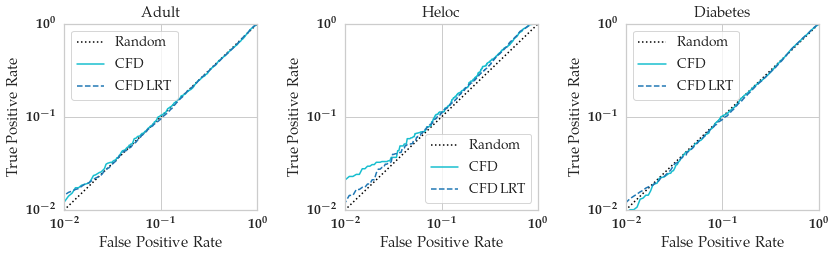

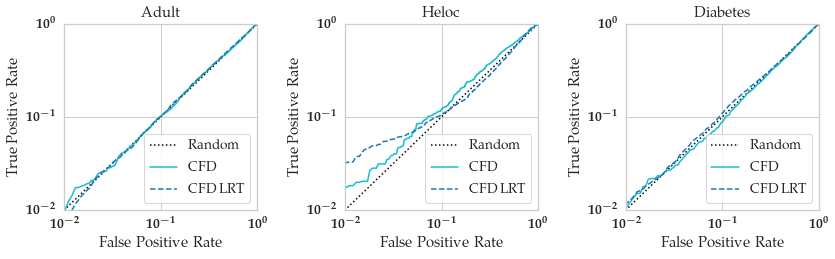

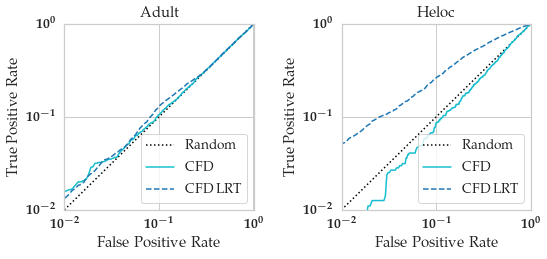

In [365]:
for method in methods:
    if method == 'gs':
        hidden_layers = [[333]*2]
        datanames = ['Adult', 'Heloc', 'Diabetes']
    elif method == 'cchvae':
        hidden_layers = [[1000]]
        datanames = ['Adult', 'Heloc']
    else:
        hidden_layers = [[1000]]
        datanames = ['Adult', 'Heloc', 'Diabetes']
    
    parameters_CE['methods'] = method
    for hidden_layer in hidden_layers:
        parameters_MODEL['hidden_layers'] = hidden_layer
        plot(parameters_DATA,
             parameters_GENERAL,
             parameters_MODEL,
             parameters_CE,
             datanames,
             flag='attack')